In [1]:
# basic python system/path library
import os
import glob
import shutil
from collections import defaultdict, OrderedDict
import time
from configparser import ConfigParser

# numerical libraries
import numpy as np
import pandas as pd

# binary file libraries
import pyarrow
import openpyxl

# HTTP library
import requests

# Compression libraries
import zipfile
import tarfile
import gzip

# plotting libraries
import matplotlib.pyplot as plt
plt.rc('axes', titlesize=30)
plt.rc('axes', labelsize=20)
import seaborn as sns
import contextily as cx

# database libraries
import pyodbc

# Geographical processing data
import geopandas as gpd
from shapely.geometry import Polygon, LineString, Point

## Funciones

In [2]:
def unzip(path_zip, unzip_dir, password=None):
    """Descomprime el fichero de entrada en un directorio de 
    salida.

    Args:
        path_zip (atr): Ruta al fichero comprimido en ZIP.
        unzip_dir (str): Directorio donde se descomprimirá el fichero.
        password (str, optional): Constraseña para descomprimir el fichero de entrada. Defaults to None.

    Returns:
        int: 0, si el proceso se ha desarrollado sin errores.
             1, en caso contrario.
    """
    file_zip = zipfile.ZipFile(path_zip, "r")
    try:
        print(f'"{path_zip}" content:')
        print(file_zip.namelist())
        file_zip.extractall(pwd=password, path=unzip_dir)
    except Exception as e:
        print(f'ERROR: Se ha producido un error al descomprimir el fichero "{file_zip}".')
        print(str(e))
        return 1

    file_zip.close()
    
    return 0

In [3]:
def get_url(url, download_dir):
    """Descarga el fichero apuntado por 'url' en el directorio 'download_dir'.
    
    Args:
        url (str): Fichero apuntado por la URL.
        download_dir (str): Directorio donde se almacenará el fichero descargado.

    Returns:
        int: Número de caracteres descargados.
             -1, en caso de error.
    """
    
    
    prefix, name = os.path.split(url)
    
    if not os.path.exists(download_dir):
        try:
            os.makedirs(download_dir, exist_ok=True)
        except IOError as e:
            print(f'ERROR: No se pudo generar el directorio de salida "{download_dir}".')
            print(str(e))
            return -1
    
    # ruta de descarga del fichero apuntado por la url
    download_path = os.path.join(download_dir, name)
    
    # obteniendo datos de la url mediante el método GET
    r = requests.get(url)
    
    # Escribiendo el fichero descargado en la ruta de descarga
    with open(download_path, 'wb') as f:
        f.write(r.content)
    
    return len(r.content)

In [120]:
def read_db_piezometry(path):
    """Lee la información contenida en el fichero MS Access que viene dado por el parámetro 'path'.

    Args:
        path (str): Ruta en disco al fichero MS Access.

    Returns:
        tuple: (pd.DataFrame piezometros, pd.DataFrame niveles)
    """

    # Conexión a MS Access
    path = path.replace(r'\\', '/')
    print(f'path={path}')    
    cnxn = pyodbc.connect(r'DRIVER={};DBQ={};UID="";PWD="";'.format('Microsoft Access Driver (*.mdb, *.accdb)', path)) 
    
    # Consulta sobre los datos de Piezometros a MS Access
    query_piezometros = pd.read_sql('SELECT * FROM 01_Piezometros', con=cnxn)
    
    # Paso a dataframe
    df_piezometros = pd.DataFrame(query_piezometros)
    
    # Consulta sobre las medias de piezometría a MS Access
    query_niveles = pd.read_sql(sql='SELECT * FROM 02_Niveles', con=cnxn, parse_dates={'FechaP':'%Y-%m-%d'})
    
    # Paso a dataframe
    df_niveles = pd.DataFrame(query_niveles)
   
    return df_piezometros, df_niveles

In [5]:
def media_ponderada_por_distancia(distances, df_measures):
    """Determina el valor de la media ponderada por el inverso de la distancia de
    las medidas dadas por el parámetro df_measures.

    Args:
        distances (np.array): Array de distancias entre puntos considerados.
        df_measures (pd.Serie): Serie de medidas tomadas.

    Returns:
        np.array: Array de medidas promedio de las magnitudes pasadas 
            ponderadas por el inverso de la distancia.
    """

    weights = 1 / distances
    
    return np.dot(weights, df_measures.to_numpy().T) / weights.sum()

In [6]:
def get_precipitations(gdf_location, gdf_nodes_grid, df_measures, mode='closest', radius_m=5000.0, field_date='fecha'):
    """Devuelve un dataframe con fechas como índices y medidas de precipitación calculadas según el 
    algoritmo dado por el parámetro 'mode'.

    Args:
        gdf_location (gpd.GeoDataFrame): GeoDataFrame con información sobre las ubicaciones de muestreo.
        gdf_nodes_grid (gdf.GeoDataFrame): GeoDataFrame con información sobre los puntos de los que 
            se dispone de medidas de precipitación.
        df_measures (pd.DataFrame): DataFrame con las medidas de precipitación, para cada punto 
        referenciado en 'gdf_nodes_grid'.
        mode (str, optional): Algoritmo empleado para el cálculo de la precipitación que se 
            asociará a cada punto dado en 'gdf_location'. Hay dos posibilidades: 
                - 'closest', asocia la precipitación del punto más cercano.
                - cualquier otro valor, que use el algoritmo del promedio de la precipitación
                    ponderado por el inverso de la distancia para los puntos con medida de 
                    precipitación más cercanos.
            Defaults to 'closest'.
        radius_m (float, optional): Distancia máxima (en metros) a los puntos considerados como 
            próximos. Defaults to 5000.
        field_date (str, optional): Nombre del campo que contiene la fecha de las mediciones de 
            precipitacion en 'df_measures'. Defaults to 'fecha'.

    Returns:
        tuple: (precipitaciones, asociaciones)
            donde
                - precipitaciones (dict), diccionario cuyas claves son los valores de los índices
                    del GeoDataFrame 'gdf_location', y cuyo valor es la precipitación estimada según el 
                    algoritmo seleccionado.
                - asociaciones (dict), diccionario que contiene la asociación realizada entre 
                    puntos de muestreo y de precipitación. Sus claves son: 
                        index_loc, index_grid y distance
                    donde 
                        - 'index_loc' (list), son loas valores de los índices del GeoDataFrame 
                            'gdf_location' que identifican cada punto de muestreo,
                        - 'index_grid' (list), es una lista con los nodos de precipitación que se relacionan
                            con cada punto de muestreo (este valor puede ser una lista de listas), y
                        - distance (list), es una lista con las distancias (en metros) de cada punto de 
                            interés a los nodos de precipitación con los que se relaciona (este valor 
                            puede ser una lista de listas).
    """

    # Diccionario de listas donde almacenaremos los resultados de puntos cercanos
    pairs = defaultdict(list)
    measure = OrderedDict()
    measure['fecha']= df_measures.loc[:, field_date].values

    # creo el buffer alrededor de cada localización
    gdf_location["buffered"] = gdf_location.buffer(radius_m)
    
    # para cada localización de medida...
    for ind in gdf_location.index:
        location = gdf_location.loc[[ind]]
        # print(f'location = {location}')
        inside = gdf_nodes_grid.geometry.within(location.buffered.values[0]) # boolean serie
        
        if inside.to_numpy().sum() == 0: # not grid points in location buffers
            continue
        
        gdf_closer_nodes = gdf_nodes_grid[inside]
    
        # Computing distances
        distances = gdf_closer_nodes.geometry.distance(location.geometry.values[0])

        pairs['index_loc'].append(ind)
        if mode.lower() == 'closest':
            # Tomamos el punto de gdf_nodes_grid más cercano dentro del buffer
            index_min_dist = distances.argmin()
            closest_index_grid = gdf_closer_nodes.index[index_min_dist]
            pairs['index_grid'].append(closest_index_grid)
            pairs['distance'].append(distances.values.min())
            measure[ind] = df_measures.loc[:, closest_index_grid].to_numpy()
        else:
            pairs['index_grid'].append(gdf_closer_nodes.index)
            pairs['distance'].append(distances.values)
            
            # Tomamos los puntos de gdf_nodes_grid dentro del buffer (media ponderada por distancia)
            measure[ind] = media_ponderada_por_distancia(distances, df_measures.loc[:, gdf_closer_nodes.index])
        
    return measure, pairs

In [7]:
def get_piezometry(gdf_location, gdf_piezo, df_measures, radius_m=5000.0, field_date='fecha'):
    """Devuelve un dataframe con fechas como índices y medidas. Para cada ubicación de
    'gdf_location', le asocia la serie temporal más larga de medidas de piezometría
    dentro de las disponibles en un radio de 'radius_m' alrededor de dicha ubicación.
    
    Args:
        gdf_location (gpd.GeoDataFrame): GeoDataFrame con información sobre las ubicaciones de muestreo.
        gdf_piezo (gdf.GeoDataFrame): GeoDataFrame con información sobre los puntos de los que 
            se dispone de medidas de piezometría.
        df_measures (pd.DataFrame): DataFrame con las medidas de precipitación, para cada punto 
            referenciado en 'gdf_piezo'.
        radius_m (float, optional): Distancia máxima (en metros) a los puntos considerados como 
            próximos. Defaults to 5000.0.
        field_date (str, optional): Nombre del campo que contiene la fecha de las mediciones de 
            piezometría en 'df_measures'. Defaults to 'fecha'.

    Returns:
        tuple: (piezometrías, asociaciones)
            donde
                - piezometrías (dict), es un diccionario cuyas claves son los valores de los índices
                    del GeoDataFrame 'gdf_location', y cuyo valor es la piezometría estimada según el 
                    algoritmo de serie de medidas piezométricas más larga de entre las ubicaciones 
                    de los piezómetros cercanos.
                - asociaciones (dict), diccionario de listas que contiene la asociación realizada entre 
                    puntos de muestreo y de precipitación. Sus claves son: 
                        index_loc, index_piezo y distance
                    donde 
                        - 'index_loc' (list), son loas valores de los índices del GeoDataFrame 
                            'gdf_location' que identifican cada punto de muestreo,
                        - 'index_piezo' (list), es una lista con los puntos de medida piezométrica que 
                            se relacionan con cada punto de muestreo, y
                        - distance (list), es una lista con las distancias (en metros) de cada punto de 
                            interés a los puntos con medidas piezométricas con los que se relaciona.
    """
    
    # Diccionario de listas donde almacenaremos los resultados de puntos cercanos
    pairs = defaultdict(list)
    measure = OrderedDict()

    # creo el buffer alrededor de cada localización
    gdf_location["buffered"] = gdf_location.buffer(radius_m)
    
    # para cada localización de medida...
    for ind in gdf_location.index:
        location = gdf_location.iloc[[ind]]
        inside = gdf_piezo.geometry.within(location.buffered.values[0]) # boolean serie
        
        if inside.sum() == 0: # not grid points in location buffers
            continue
        
        gdf_close_nodes = gdf_piezo[inside.values]
    
        # Computing distances
        distances = gdf_piezo.geometry.distance(location.geometry.values[0])
        # print(f'Nodos más cercanos = {gdf_close_nodes.index}')
        #print(f'Distancias de los nodos más cercanos = {distances}')
        #break    
        # Eligiendo la serie más larga de las disponibles en el buffer de 'radius_m' metros
        better_index = None
        lon_serie = -1
        for i in gdf_close_nodes.index:
            n_measures = df_measures.loc[i,'fecha'].values.size
            if better_index is None or lon_serie < n_measures:
                better_index = i
                lon_serie = n_measures
        # Tomamos la serie más larga de medidas piezometricas
        measure[ind] = df_measures.loc[better_index,['fecha', 'Cota_NP_msnm']]
        
        pairs['index_piezo'].append(better_index)
        pairs['index_loc'].append(ind)
        pairs['distance'].append(distances[better_index])
            
        
    return measure, pairs

## Parámetros del notebook

In [8]:
# Lectura del fichero de configuración
config = ConfigParser(inline_comment_prefixes="#")
config.read("config.ini" )

['config.ini']

In [9]:
# List all contents
print("List all contents")
for section in config.sections():
    for option in config.options(section):
        print(f"{section}: {option} = {config.get(section, option)} (type = {type(config.get(section, option))})")

List all contents
directories: data_dir = ./data (type = <class 'str'>)
directories: output_dir = ./results (type = <class 'str'>)
urls: piezometry_url = https://www.miteco.gob.es/es/cartografia-y-sig/ide/descargas/basedatospiezometria_tcm30-533415.zip (type = <class 'str'>)
urls: precipitations_url = https://www.aemet.es/documentos/es/serviciosclimaticos/cambio_climat/datos_diarios/dato_observacional/rejilla_5km/v2/Serie_AEMET_v2_pcp_1951a2020_txt.tar.gz (type = <class 'str'>)
paths: locations_file = Point_Sampling_Murcia_desc.txt (type = <class 'str'>)
paths: out_closest_prepip = historico_precipitaciones_punto_mas_cercano.csv (type = <class 'str'>)
paths: out_interp_precip = historico_precipitaciones_ponderado_distancia.csv (type = <class 'str'>)
paths: out_longer_piezo = historico_piezometrias.csv (type = <class 'str'>)
buffer: radius = 5000 (type = <class 'str'>)
fields: location_id = FID (type = <class 'str'>)
fields: location_label = FID (type = <class 'str'>)
fields: location_l

## 1. Puntos de muestreo

Es un fichero en formato CSV que contiene información de objetos puntuales. Los campos están separados por ';'

In [10]:
locations_file = config.get('paths', 'locations_file')
df_loc = pd.read_csv(locations_file, sep=';', decimal=',')

Establezco como índice del *DataFrame* la columna dada por el campo 'location_id' en el fichero *config.ini*.

In [11]:
id_loc = config.get('fields', 'location_id')
df_loc = df_loc.set_index(id_loc, drop=False)
print(f'Campo de índice del DataFrame de localizaciones de muestreo = {id_loc}')

Campo de índice del DataFrame de localizaciones de muestreo = FID


¿Son únicas las claves dadas por el campo *location_label* en el fichero *config.ini*?

In [14]:
label = config.get('fields', 'location_label')
num_locatizaciones = len(df_loc.index)
num_distinct_labels = np.unique(df_loc.loc[:, label].to_numpy()).size
if num_locatizaciones != num_distinct_labels:
    print(f'Las etiquetas se repiten. Tenemos un problema con este campo.')
    u, c = np.unique(df_loc.loc[:, label].to_numpy(), return_counts=True)
    dup_el = u[c > 1]
    dup_count = c[c > 1]
    print(f'Hay {dup_el.size} etiquetas repetidas.')
    for e, n in zip(dup_el, dup_count):
        print(f'"{e}" -> {n} veces repetido')
        
    df_dup = df_loc[df_loc['PS_ID'] == dup_el[0]]
    print('*' * 50)
    print(f'PS_ID repetido = {dup_el[0]}')
    print(df_dup.loc[:, ['X', 'Y', 'Lon_ETRS89', 'Lat_ETRS89']])
else:
    print(f'El campo "{label}" contiene valores únicos para las localizaciones de muestreo.')

El campo "FID" contiene valores únicos para las localizaciones de muestreo.


Información sobre el objeto DataFrame generado tras la lectura del fichero.

In [16]:
print(df_loc.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2194 entries, 0 to 2193
Data columns (total 38 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   FID         2194 non-null   int64  
 1   fid_        2194 non-null   int64  
 2   E           2194 non-null   float64
 3   N           2194 non-null   float64
 4   ADA_ID      2194 non-null   int64  
 5   VELOCITY    2194 non-null   float64
 6   X           2194 non-null   float64
 7   Y           2194 non-null   float64
 8   SATELLITE   2194 non-null   object 
 9   GEOMETRY    2194 non-null   object 
 10  TRACK       2194 non-null   int64  
 11  FRAME       2194 non-null   object 
 12  INIT_DATE   2194 non-null   int64  
 13  FINAL_DATE  2194 non-null   int64  
 14  PIXEL_SIZE  2194 non-null   int64  
 15  SOFTWARE    2194 non-null   object 
 16  PAPERS      2194 non-null   object 
 17  COHERENCE   2194 non-null   float64
 18  Lon_ETRS89  2194 non-null   float64
 19  Lat_ETRS89  2194 non-null  

Si existe un campo llamado *GEOMETRY*, lo elimino

In [17]:
if 'GEOMETRY' in df_loc.columns:
    df_loc = df_loc.drop('GEOMETRY', axis=1)

Echamos un vistazo al DataFrame.

In [18]:
df_loc.head()

FID  fid_              E             N  ADA_ID  VELOCITY        X  \
FID                                                                      
0      0     3  608055.779631  4.159782e+06      30   -0.6987 -1.77625   
1      1     4  608136.302137  4.159228e+06      30   -0.7051 -1.77542   
2      2     7  608278.954313  4.159600e+06      30   -1.1283 -1.77375   
3      3     8  608281.358457  4.159415e+06      30   -1.0702 -1.77375   
4      4     9  608283.776992  4.159230e+06      30   -0.9726 -1.77375   

            Y SATELLITE  TRACK  ... emb_aux  red_trans  Moves  SubsEsp  \
FID                             ...                                      
0    37.57875        S1      8  ...                  0                   
1    37.57375        S1      8  ...                  0                   
2    37.57708        S1      8  ...                  0                   
3    37.57542        S1      8  ...                  0                   
4    37.57375        S1      8  ...                  0                   

    QAFI_trace QAFI_vecto  CODE_18  pendientes  Subsidence   Proceso  
FID                                                                   
0            1          1      242     1.37637           4  Sub_Agua  
1            1          1      242     1.19172           3  Sub_Agua  
2            1          1      212     1.52033           4  Sub_Agua  
3            1          1      212     1.38488           4  Sub_Agua  
4            1          1      242     1.18876           3  Sub_Agua  

[5 rows x 37 columns]

Queremos toda información en el sistema de referencia proyectado, dado por el parámetro '*location_projected*' del fichero *config.ini*. Comprobamos entonces los parámetros que representan la longitud (*location_lon_proj*) y latitud (*location_lat_proj*) en coordenadas proyectadas y creamos el *GeoDataFrame* correspondiente. De no estar definidas esas coordenadas, usamos las dadas en el sistema de referencia geográfico ((*location_lon_geo*, *location_lat_geo*)) para generar el *GeoDataFrame*.

In [19]:
gdf_loc = None
if len(config.get('fields', 'location_lon_proj')) > 0:
    print(f"Campos de coordenadas proyectadas de entrada: ({config.get('fields', 'location_lon_proj')}, {config.get('fields', 'location_lat_proj')})")
    geometry = gpd.points_from_xy(df_loc.loc[:,config.get('fields', 'location_lon_proj')], \
                                 df_loc.loc[:,config.get('fields', 'location_lat_proj')])
    gdf_loc = gpd.GeoDataFrame(df_loc, crs=config.get('crs', 'location_projected'), geometry=geometry)
else:
    print(f"Campos de coordenadas geográficas de entrada: ({config.get('fields', 'location_lon_geo')}, {config.get('fields', 'location_lat_geo')})")
    geometry = gpd.points_from_xy(df_loc.loc[:,config.get('fields', 'location_lon_geo')], \
                              df_loc.loc[:,config.get('fields', 'location_lat_geo')])
    gdf_loc = gpd.GeoDataFrame(df_loc, crs=config.get('crs', 'location_geographic'), geometry=geometry)

Campos de coordenadas proyectadas de entrada: (Lon_ETRS89, Lat_ETRS89)


Reproyectamos al sistema de referencia proyectado común para todas las fuentes de datos (*final_projected*)

In [20]:
# Reproyectamos la información a un sistema de coordenadas proyectadas común a todos los conjuntos 
# de datos de entrada del notebook: queremos trabajar con unidades de metros (m)
gdf_loc = gdf_loc.to_crs(config.get('crs', 'final_projected'))

Muestro de las primeras 5 filas del objeto *GeoDataFrame*. Ahora, se ha creado una nueva columna **geometry** que define cada objeto representado en los registros del fichero (puntos). Vienen dados en el sistema de referencia proyectado.

In [21]:
print(gdf_loc.head())

     FID  fid_              E             N  ADA_ID  VELOCITY        X  \
FID                                                                      
0      0     3  608055.779631  4.159782e+06      30   -0.6987 -1.77625   
1      1     4  608136.302137  4.159228e+06      30   -0.7051 -1.77542   
2      2     7  608278.954313  4.159600e+06      30   -1.1283 -1.77375   
3      3     8  608281.358457  4.159415e+06      30   -1.0702 -1.77375   
4      4     9  608283.776992  4.159230e+06      30   -0.9726 -1.77375   

            Y SATELLITE  TRACK  ... red_trans  Moves  SubsEsp  QAFI_trace  \
FID                             ...                                         
0    37.57875        S1      8  ...         0                           1   
1    37.57375        S1      8  ...         0                           1   
2    37.57708        S1      8  ...         0                           1   
3    37.57542        S1      8  ...         0                           1   
4    37.57375      

Genero una gráfica con las ubicaciones del fichero.

Output plot path = "C:\Users\Cesar\desarrollos\GITLAB\sarai_piezo_precip\results\localizaciones_de_muestreo.jpg"


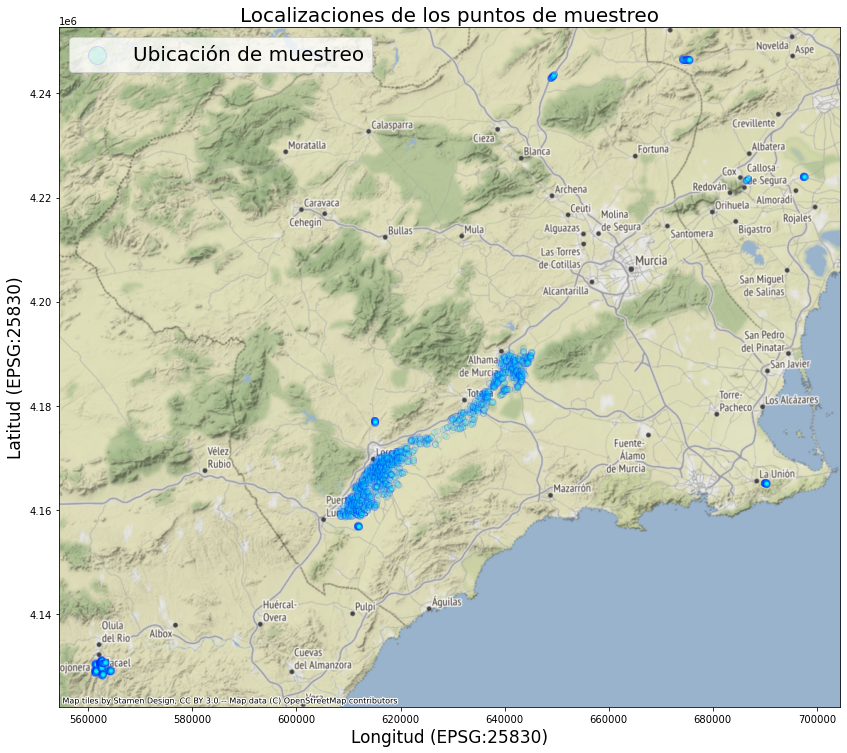

In [22]:
plt.rcParams["figure.figsize"] = (15,12.5)

ax = gdf_loc.plot(color='cyan', edgecolor='blue', alpha=0.1, marker='o', label='Ubicación de muestreo')
cx.add_basemap(ax, crs=gdf_loc.crs.to_string())
plt.legend(loc='upper left', prop={'size':20}, markerscale=3)
plt.xlabel(f'Longitud ({config.get("crs", "final_projected")})', fontsize=17)
plt.ylabel(f'Latitud ({config.get("crs", "final_projected")})', fontsize=17)
plt.title('Localizaciones de los puntos de muestreo', fontsize=20)
output_dir = os.path.abspath(config.get('directories', 'output_dir'))
if not os.path.exists(output_dir):
    try:
        os.makedirs(output_dir)
    except IOError:
        print(f'ERROR: No se pudo crear el directorio de salida "{output_dir}".')
        print('Genérelo de forma manual y vuelva a ejecutar esta celda.')
plot_out = os.path.join(output_dir, 'localizaciones_de_muestreo.jpg')
print(f'Output plot path = "{plot_out}"')
plt.savefig(plot_out, dpi=300)

plt.show()

## 2. Precipitaciones

La medida de las precipitaciones se obtiene a partir de la URL proporcionada a través de la
variable *precipitations_url*, en el fichero *config.ini*. Por defecto, tiene asignada la dirección web de un fichero empaquetado y comprimido en formato *.tar.gz*.

Tras descomprimir y desempaquetar pordemos acceder al contenido. Básicamente se trata de: 

- Un fichero con información detallada al respecto del contenido del paquete descargado (**README.txt**).
- las ubicaciones de los puntos de la malla distribuida de forma uniforme por el territorio nacional en cuadrículas de 5x5 km (**maestro_red_hr_SPAIN.txt**).
- las medidas de precipitación interpolada en esos nodos (**pcp_red_SPAIN_1951-2020.txt**). La resolución temporal es diaria. Ha sido registrada en el periodo de 1951 a 2020. Se espera que estos datos se vayan actualizando en la web de la AEMET.


###  2.1. Carga de las ubicaciones de los nodos de la malla de precipitación

In [23]:
precipitations_url = config.get('urls', 'precipitations_url')
data_dir = config.get('directories', 'data_dir')

root, name_prec = os.path.split(precipitations_url)
precip_path = os.path.abspath(os.path.join(data_dir, name_prec))

print(f"Fichero de precipitaciones: '{precip_path}'")

Fichero de precipitaciones: 'C:\Users\Cesar\desarrollos\GITLAB\sarai_piezo_precip\data\Serie_AEMET_v2_pcp_1951a2020_txt.tar.gz'


Si no se ha hecho ya, descargamos y descomprimimos el fichero de precipitaciones.

In [24]:
res_get = 1

if not os.path.exists(precip_path):
    print(f"Descargando: '{precipitations_url}'. Por favor, espere.")
    res_ges = get_url(precipitations_url, data_dir)

if res_get > 0:
    # descomprimo el fichero
    precip_compress = tarfile.open(precip_path)
    precip_compress.extractall(data_dir)
    precip_compress.close()
    
# gunzip fichero de datos
patron = os.path.abspath(os.path.join(data_dir, '*.txt.gz'))
print(f'Buscando ficheros con el patron: {patron}')
precip_gz = glob.glob(patron)
precip_path = None
if len(precip_gz):
    print(f'Fichero a desempaquetar: {precip_gz[0]}')
    precip_path = precip_gz[0][:-3]
    if not os.path.exists(precip_path):
        with gzip.open(precip_gz[0], 'rb') as f_in:
            with open(precip_path, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)

Descargando: 'https://www.aemet.es/documentos/es/serviciosclimaticos/cambio_climat/datos_diarios/dato_observacional/rejilla_5km/v2/Serie_AEMET_v2_pcp_1951a2020_txt.tar.gz'. Por favor, espere.
Buscando ficheros con el patron: C:\Users\Cesar\desarrollos\GITLAB\sarai_piezo_precip\data\*.txt.gz
Fichero a desempaquetar: C:\Users\Cesar\desarrollos\GITLAB\sarai_piezo_precip\data\pcp_red_SPAIN_1951-2020.txt.gz


El fichero maestro es el que contiene la ubicación de los nodos de la malla de precipitaciones.

In [39]:
master_path = os.path.abspath(os.path.join(data_dir, 'maestro_red_hr_SPAIN.txt'))
df_master_precip = pd.read_csv(master_path, header=None, delim_whitespace=True)
print(df_master_precip.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16156 entries, 0 to 16155
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       16156 non-null  int64  
 1   1       16156 non-null  float64
 2   2       16156 non-null  float64
 3   3       16156 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 505.0 KB
None


Las coordenadas de los nodos de precipitación interpolada vienen dada en el sistema de referencia geográfico.

In [40]:
# Comprobamos la existencia de coordenadas proyectadas. Si no existen, elegimos las geográficas y reproyectamos.
lon_name = config.get('fields', 'precip_lon_geo')
lat_name = config.get('fields', 'precip_lat_geo')
sr = config.get('crs', 'precip_geographic')
if len(config.get('fields', 'precip_lon_proj')) > 0:
    lon_name = config.get('fields', 'precip_lon_proj')
    lat_name = config.get('fields', 'precip_lat_proj')
    sr = config.get('crs', 'precip_projected')

print(f"(longitud, latitud, sr) = ({lon_name}, {lat_name}, {sr})")
# Establecemos los nombres de columnas del fichero, ya que inicialmente no tiene
df_master_precip.columns = ['ID', lon_name, lat_name, 'height']
# y establecemos el índice al campo 'ID'
df_master_precip = df_master_precip.set_index('ID', drop=False)

(longitud, latitud, sr) = (longitude, latitude, EPSG:4326)


Georeferenciamos la información del DataFrame de localizaciones de precipitación

In [41]:
geometry = gpd.points_from_xy(df_master_precip[lon_name], df_master_precip[lat_name])
gdf_master_precip = gpd.GeoDataFrame(df_master_precip, crs=sr, geometry=geometry)

Reproyectamos al sistema de referencia común proyectado *final_projected*

In [43]:
gdf_master_precip = gdf_master_precip.to_crs(config.get('crs', 'final_projected'))

In [44]:
# mostramos información sobre el nuevo objeto GeoDataFrame de puntos con medidas de precipitación
print(gdf_master_precip.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 16156 entries, 1 to 16156
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   ID         16156 non-null  int64   
 1   longitude  16156 non-null  float64 
 2   latitude   16156 non-null  float64 
 3   height     16156 non-null  float64 
 4   geometry   16156 non-null  geometry
dtypes: float64(3), geometry(1), int64(1)
memory usage: 757.3 KB
None


In [45]:
print(gdf_master_precip.head())

    ID  longitude  latitude  height                        geometry
ID                                                                 
1    1     -2.948    35.307   102.0  POINT (504727.295 3907090.301)
2    2     -5.323    35.898    58.0  POINT (290346.157 3975128.078)
3    3     -5.630    36.049   124.0  POINT (263085.280 3992584.413)
4    4     -5.568    36.049   186.0  POINT (268671.515 3992435.191)
5    5     -5.507    36.049   163.0  POINT (274167.567 3992291.857)


In [46]:
# Comprobación de sistemas de referencia para localizaciones de muestreo y puntos con medida de precipitación
print(f'gdf_loc.crs = {gdf_loc.crs}')
print(f'gdf_master_precip.crs = {gdf_master_precip.crs}')

gdf_loc.crs = EPSG:25830
gdf_master_precip.crs = EPSG:25830


Muestro la malla y los puntos de muestreo sobre los que vamos a trabajar.

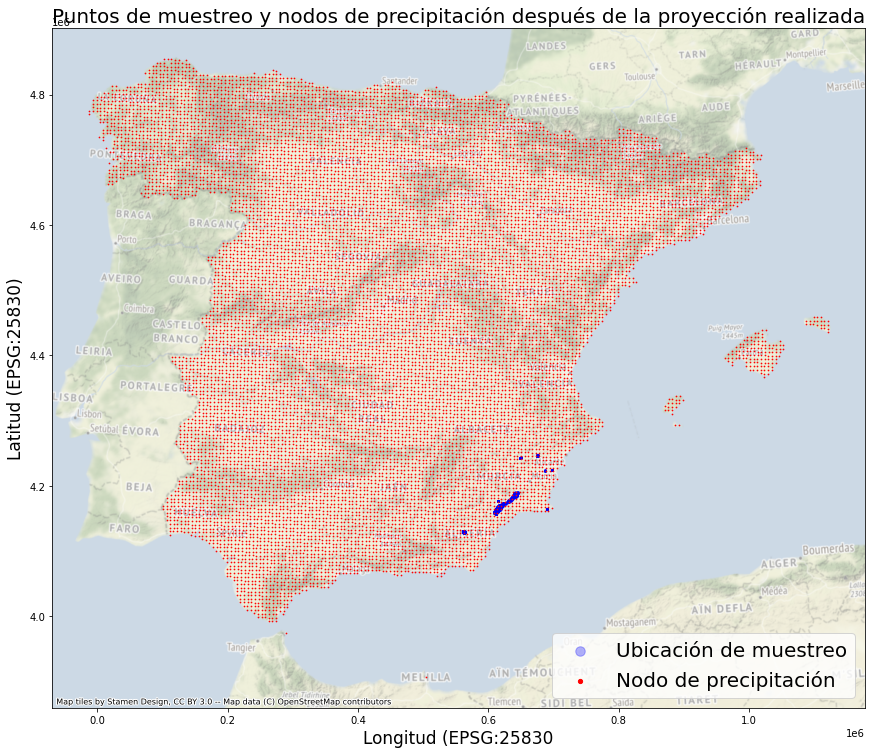

In [47]:
plt.rcParams["figure.figsize"] = (15,12.5)

ax = gdf_loc.plot(color='blue', alpha=0.3, marker='.', markersize=10, label='Ubicación de muestreo')
gdf_master_precip.plot(ax=ax, color='red', edgecolor='red', marker='.', markersize=2, label='Nodo de precipitación')

cx.add_basemap(ax, crs=gdf_loc.crs.to_string(), alpha=0.5)
plt.legend(loc='lower right', prop={'size':20}, markerscale=6)
plt.xlabel(f"Longitud ({config.get('crs', 'final_projected')}", fontsize=17)
plt.ylabel(f"Latitud ({config.get('crs', 'final_projected')})", fontsize=17)
plt.title('Puntos de muestreo y nodos de precipitación después de la proyección realizada', fontsize=20)
output_dir = os.path.abspath(config.get('directories', 'output_dir'))
plot_out = os.path.join(output_dir, 'todos_nodos_precipitacion_y_localizaciones_de_muestreo.jpg')
plt.savefig(plot_out, dpi=300)

plt.show()

**Limito la malla al cuadrado determinado por las coordenadas extremas de las localizaciones de muestreo.**

In [48]:
big_radius = float(config.get('buffer', 'radius')) + 1000 # amplío el tamaño de buffer propuesto en 1000 m alrededor de cada punto
gdf_loc["buffered"] = gdf_loc.buffer(big_radius) 

# cambio la geometría por defecto de puntos a buffers
gdf_loc = gdf_loc.set_geometry("buffered")

# coordenadas extremas de los buffers
minx, miny, maxx, maxy = gdf_loc.total_bounds

print('Área de interés:')
print(f'\t(minx, miny, maxx, maxy) = ({minx}, {miny}, {maxx}, {maxy})')

# establezco de nuevo la geometría por defecto a la columna de puntos
gdf_loc = gdf_loc.set_geometry("geometry")

Área de interés:
	(minx, miny, maxx, maxy) = (555108.209879, 4122063.56834, 703649.418724, 4252778.75332)


Genero un polígono a partir de los límites obtenidos en el punto anterior

In [49]:
pol_geom = Polygon([(minx, miny), (minx, maxy), (maxx, maxy), (maxx, miny), (minx, miny)])
polygon = gpd.GeoDataFrame(index=[0], crs= config.get('crs', 'final_projected'), geometry=[pol_geom])  

Obtengo los puntos de la malla dentro de los límites

In [50]:
inside = gdf_master_precip.within(polygon.geometry[0])
print(f'Número de nodos de precipitación dentro del área límite = {inside.sum()}')

Número de nodos de precipitación dentro del área límite = 516


In [51]:
# filtro la malla de precipitaciones al área de interés
gdf_reduced_grid = gdf_master_precip[inside]

# reproyecto a ETRS 25830
gdf_reduced_grid = gdf_reduced_grid.to_crs(config.get('crs', 'final_projected'))
print(f'Número de nodos = {len(gdf_reduced_grid.index)}')
print(gdf_reduced_grid.head())

Número de nodos = 516
        ID  longitude  latitude  height                        geometry
ID                                                                     
1199  1199     -2.359    37.290  1112.0  POINT (556816.646 4127236.357)
1200  1200     -2.297    37.288   903.0  POINT (562313.892 4127053.528)
1201  1201     -2.234    37.286   743.0  POINT (567900.092 4126875.018)
1202  1202     -2.171    37.284   665.0  POINT (573486.610 4126700.227)
1203  1203     -2.109    37.282   593.0  POINT (578984.798 4126528.319)


Genero de nuevo una gráfica con el subconjunto de nodos de precipitación y las estaciones de muestreo.

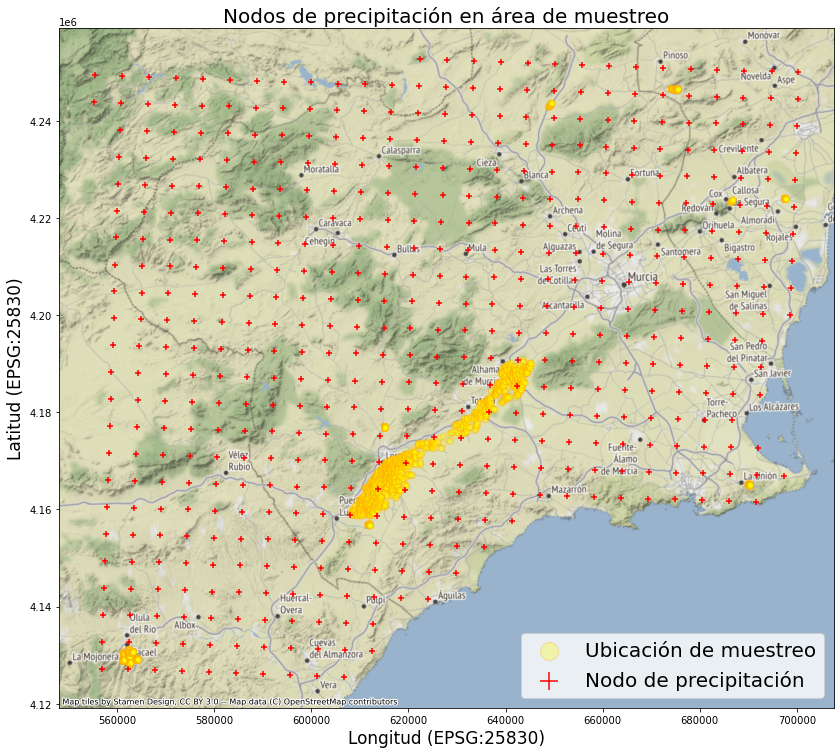

In [52]:
plt.rcParams["figure.figsize"] = (15,12.5)

ax = gdf_loc.plot(color='yellow', edgecolor='orange', marker='o', alpha=0.3, label='Ubicación de muestreo')

# gdf_reduced_grid.plot(ax=ax, marker='+')

gdf_reduced_grid.plot(ax=ax, color='red', marker='+', label='Nodo de precipitación')
cx.add_basemap(ax, crs=gdf_loc.crs.to_string())
plt.legend(loc='lower right', prop={'size':20}, markerscale=3)
plt.xlabel(f'Longitud ({config.get("crs", "final_projected")})', fontsize=17)
plt.ylabel(f'Latitud ({config.get("crs", "final_projected")})', fontsize=17)
plt.title('Nodos de precipitación en área de muestreo', fontsize=20)
output_dir = os.path.abspath(config.get('directories', 'output_dir'))
plot_out = os.path.join(output_dir, 'nodos_precipitacion_En_area_de_muestreo.jpg')
plt.savefig(plot_out, dpi=300)

plt.show()

Zoom a las ubicaciones y su posición relativa a la malla de precipitaciones

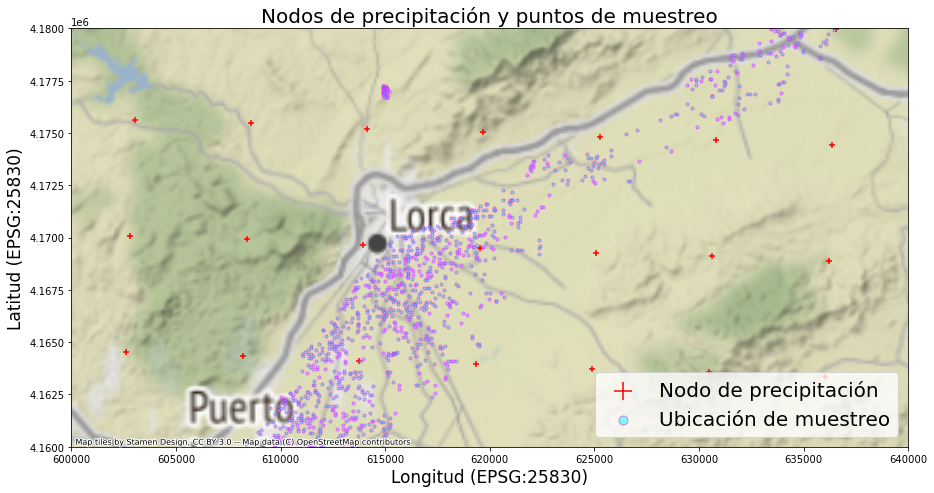

In [53]:
plt.rcParams["figure.figsize"] = (15,12.5)

ax = gdf_reduced_grid.plot(color='red', marker='+', label='Nodo de precipitación')

# gdf_reduced_grid.plot(ax=ax, marker='+')

gdf_loc.plot(ax=ax, color='cyan', edgecolor='magenta', marker='.', alpha=0.5, label='Ubicación de muestreo')
cx.add_basemap(ax, crs=gdf_loc.crs.to_string())
plt.legend(loc='lower right', prop={'size':20}, markerscale=3)

ax.set_xlim(600000, 640000)
ax.set_ylim(4160000, 4180000)

plt.xlabel(f'Longitud ({config.get("crs", "final_projected")})', fontsize=17)
plt.ylabel(f'Latitud ({config.get("crs", "final_projected")})', fontsize=17)
plt.title('Nodos de precipitación y puntos de muestreo', fontsize=20)
plot_out = os.path.join(output_dir, 'zoom_distribucion_nodos_precipitacion_y_puntos_muestreo.jpg')
plt.savefig(plot_out, dpi=300)

plt.show()



In [54]:
# Comprobación del SR del GeoDataFrame
print(gdf_reduced_grid.crs)

EPSG:25830


In [55]:
print(f'Tamaño del DataFrame de lugares de muestreo (filas, columnas) = {gdf_loc.shape}')

Tamaño del DataFrame de lugares de muestreo (filas, columnas) = (2194, 39)


In [56]:
# Campos que forman parte del GeoDataFrame de nodos de precipitación dentro del área de estudio
print(gdf_reduced_grid.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 516 entries, 1199 to 3528
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   ID         516 non-null    int64   
 1   longitude  516 non-null    float64 
 2   latitude   516 non-null    float64 
 3   height     516 non-null    float64 
 4   geometry   516 non-null    geometry
dtypes: float64(3), geometry(1), int64(1)
memory usage: 24.2 KB
None


In [57]:
print(gdf_reduced_grid.head())

        ID  longitude  latitude  height                        geometry
ID                                                                     
1199  1199     -2.359    37.290  1112.0  POINT (556816.646 4127236.357)
1200  1200     -2.297    37.288   903.0  POINT (562313.892 4127053.528)
1201  1201     -2.234    37.286   743.0  POINT (567900.092 4126875.018)
1202  1202     -2.171    37.284   665.0  POINT (573486.610 4126700.227)
1203  1203     -2.109    37.282   593.0  POINT (578984.798 4126528.319)


### 2.2. Lectura del fichero con medidas de precipitación

Leo la primera fila del fichero de precipitación. Está ubicado en el directorio *data_dir* dado por el fichero *config.ini*. El nombre del fichero es el establecido por el paquete descargado.

In [58]:
precip_path = os.path.abspath(os.path.join(data_dir, 'pcp_red_SPAIN_1951-2020.txt'))

precipitacion = open(precip_path)
first = precipitacion.readline()
print(f'Numero de campos que contiene la primera línea = {len(first.split())}')

Numero de campos que contiene la primera línea = 16157


Leo todo el contenido del fichero. Dado que se trata de un fichero enorme (más de 3 GB), su lectura puede llevar minutos. Es por eso que si se lee por primera vez, se almacena en formato binario. Eso acelera de forma dramática las siguientes lecturas, pasando de minutos a segundos. 

Se muestra el tiempo que se ha tardado en realizar esta operación.

In [59]:

binary_precip_path = os.path.abspath(os.path.join(data_dir, 'pcp_red_SPAIN_1951-2020.feather'))

if not os.path.exists(binary_precip_path):
    # Reading text format file
    ini_time = int(time.time())
    df_precip = pd.read_csv(precip_path, header=None, delim_whitespace=True)
    final_time = int(time.time())
    print(f'Tiempo de lectura de fichero de texto de precipitaciones = {final_time - ini_time} s')
    # saving dataframe to binary format for efficiency purposes
    # Almaceno en fichero con formato binario (tipo 'feather') el DataFrame de precipitaciones
    df_precip.columns = ['fecha'] + [str(i) for i in range(1, df_precip.shape[1])]
    ini_time = int(time.time())
    df_precip.to_feather(binary_precip_path)
    final_time = int(time.time())
    print(f'Tiempo invertido en la escritura de la información de precipitación en fichero binario = {final_time - ini_time} s')
    print(f'Fichero binario = "{binary_precip_path}"')
else:
    # Lectura del fichero binario de precipitaciones
    ini_time = int(time.time())
    df_precip = pd.read_feather(binary_precip_path)
    final_time = int(time.time())
    print(f'Tiempo invertido en la lectura del fichero de precipitaciones en formato binario = {final_time - ini_time} s')


Tiempo de lectura de fichero de texto de precipitaciones = 311 s
Tiempo invertido en la escritura de la información de precipitación en fichero binario = 4 s
Fichero binario = "C:\Users\Cesar\desarrollos\GITLAB\sarai_piezo_precip\data\pcp_red_SPAIN_1951-2020.feather"


In [60]:
# Información sobre el fichero de precipitaciones cargado en memoria
print(df_precip.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25568 entries, 0 to 25567
Columns: 16157 entries, fecha to 16156
dtypes: float64(16156), int64(1)
memory usage: 3.1 GB
None


In [61]:
print(df_precip.head())

      fecha     1      2      3      4      5      6      7      8      9  \
0  19510101  0.37   8.05  17.80  17.89  16.11  15.42  15.96  16.79  18.46   
1  19510102  4.29  18.46   8.65   9.47  10.30   6.03   5.98   6.18   6.86   
2  19510103  0.00   1.55   0.00   0.93   1.65   0.00   0.00   0.00   0.89   
3  19510104  0.00   0.32   2.01   1.99   1.92   2.02   2.16   2.27   2.30   
4  19510105  0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   

   ...  16147  16148  16149  16150  16151  16152  16153  16154  16155  16156  
0  ...  24.89  23.23  21.89  20.60  25.13  24.03  23.06  23.01  22.63  19.48  
1  ...  19.31  19.80  20.05  20.13  14.14  15.59  16.81  17.68  18.37  19.40  
2  ...   3.17   2.83   2.55   2.27   0.98   1.04   1.13   1.47   1.68   1.13  
3  ...   0.25   0.26   0.25   0.24   0.23   0.30   0.33   0.31   0.30   0.32  
4  ...   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00  

[5 rows x 16157 columns]


In [62]:
print('Cabecera del fichero')
print(df_precip.columns.values)

Cabecera del fichero
['fecha' '1' '2' ... '16154' '16155' '16156']


Cambio los nombres de las columnas de este dataframe. Se supone que cada una de ellas representa la medida de uno de los nodos de precipitación dados por el fichero maestro. Ese dato es numérico.

In [65]:
df_precip.columns = [config.get('fields', 'precip_date')] + [int(col_name) for col_name in df_precip.columns.values[1:]]

In [66]:
print('Nueva cabecera del fichero')
print(df_precip.columns.values)

Nueva cabecera del fichero
['fecha' 1 2 ... 16154 16155 16156]


Proceso el campo *precip_date* del DataFrame para reconocerlo y procesarlo como un campo de tipo 'datetime'.

In [67]:
df_precip[config.get('fields', 'precip_date')] = pd.to_datetime(df_precip[config.get('fields', 'precip_date')], format='%Y%m%d')

In [68]:
# la primera columna es la fecha
print(df_precip.loc[[0,1,2,3],[config.get('fields', 'precip_date')]])

       fecha
0 1951-01-01
1 1951-01-02
2 1951-01-03
3 1951-01-04


In [69]:
df_precip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25568 entries, 0 to 25567
Columns: 16157 entries, fecha to 16156
dtypes: datetime64[ns](1), float64(16156)
memory usage: 3.1 GB


Fíjese en que ahora la fecha es un campo de typo *datetime*.

### 2.3. Asociación de precipitación a cada punto de muestreo

Trabajaremos punto por punto. Es decir, **para cada localización de muestreo**, buscaremos

- los **nodos de precipitación en la zona de influencia del buffer definido alrededor de cada punto de muestreo**, y
- el **nodo de preiciptación más cercano**.

#### 2.3.1. Estimación mediante la media ponderada al inverso de la distancia a los nodos de precipitación más cercanos

In [72]:
print("Radio de influencia de cada punto de muestreo = {} m (valor de tipo {})".format(float(config.get('buffer', 'radius')), \
                                                                                       type(float(config.get('buffer', 'radius')))))
measures_buffer, pairs_buffer = get_precipitations(gdf_loc, gdf_reduced_grid, df_precip, mode='buffer', \
                                                   radius_m=float(config.get('buffer', 'radius')), \
                                                   field_date=config.get('fields', 'precip_date'))


Radio de influencia de cada punto de muestreo = 5000.0 m (valor de tipo <class 'float'>)


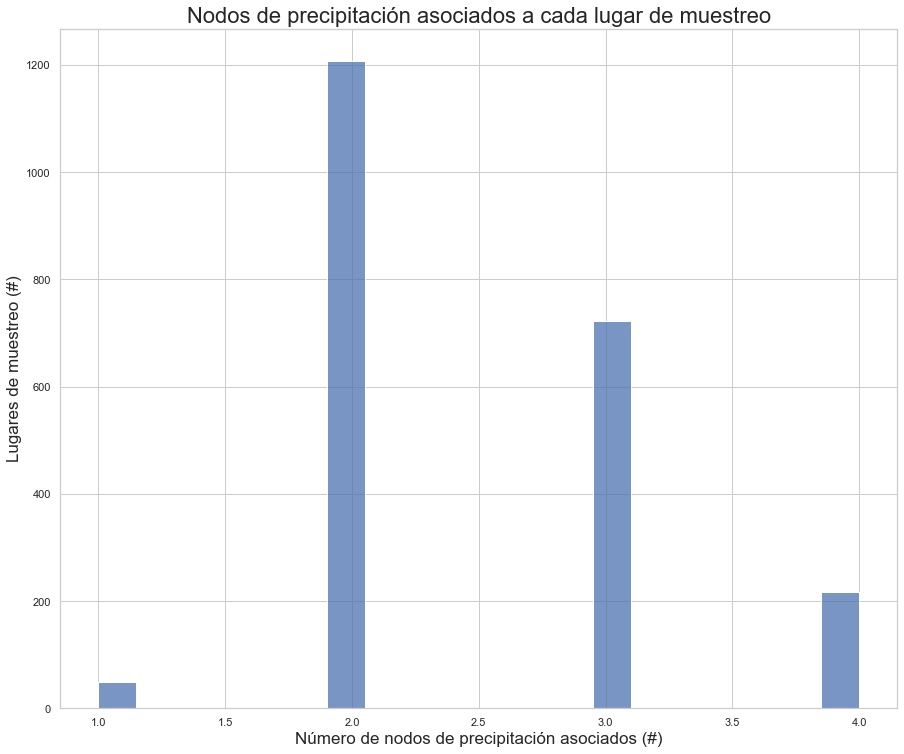

In [73]:
sns.set_theme(style="whitegrid")
num_nodos = [len(n.to_list()) for n in pairs_buffer['index_grid']]
sns.histplot(num_nodos)
plt.title('Nodos de precipitación asociados a cada lugar de muestreo', fontsize=22)
plt.xlabel("Número de nodos de precipitación asociados (#)", fontsize=17)
plt.ylabel("Lugares de muestreo (#)", fontsize=17)
output_dir = os.path.abspath(config.get('directories', 'output_dir'))
plot_out = os.path.join(output_dir, 'histograma_asociacion_nodos_precipitacion-puntos_muestreo.jpg')
plt.savefig(plot_out, dpi=300)

plt.show()

Me hago con la columna que identifica cada estación mediante una cadena de texto '*location_label*', para mostrar explícitamente información sobre el punto de muestreo. Los valores de este campo **deben ser únicos** porque se generará un fichero de salida cuyas columnas tengan los valores de este campo.

In [76]:
old_column_names = list(measures_buffer.keys())
# print(old_column_names)
new_column_names = [old_column_names[0]] + \
    gdf_loc.loc[pairs_buffer['index_loc'], config.get('fields', 'location_label')].to_list()

print(f"len(old_column_names) = {len(old_column_names)}, len(new_column_names) = {len(new_column_names)}")
print(f"Número de campos únicos de entrada (location_ID : {config.get('fields', 'location_ID')}) = {len(np.unique(np.array(old_column_names)))}")
print(f"Número de campos únicos de salida (location_label : {config.get('fields', 'location_label')}) = {len(np.unique(np.array(new_column_names)))}")
map_col_names = {k:v for k, v in zip(old_column_names, new_column_names)}

len(old_column_names) = 2195, len(new_column_names) = 2195
Número de campos únicos de entrada (location_ID : FID) = 2195
Número de campos únicos de salida (location_label : FID) = 2195


Generamos el DataFrame de medidas de precipitación interpolada a partir del diccionario devuelto como primer parámetro de la función *get_precipitations* en modo *buffer* (cálculo de precipitaciones usando la media ponderada del inverso de la distancia a los nodos dentro de la zona de influencia de cada punto de muestreo).

In [77]:
df_measures_buffer = pd.DataFrame.from_dict(measures_buffer)

Renombramos las columnas a los valores del campo apuntado por el parámetro *location_label*.

In [78]:
df_measures_buffer.rename(columns=map_col_names, inplace=True)

In [79]:
print(f'dimensiones de measures_buffer = {df_measures_buffer.shape}')
print(df_measures_buffer.info())

dimensiones de measures_buffer = (25568, 2195)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25568 entries, 0 to 25567
Columns: 2195 entries, fecha to 2193
dtypes: datetime64[ns](1), float64(2194)
memory usage: 428.2 MB
None


Comprobamos las medidas de la interpolación con el inverso de la distancia para el primer lugar de muestreo (el dado por el índice 0)

In [80]:
print(f"Indice del lugar de muestreo considerado = {pairs_buffer['index_loc'][0]}")
print(f"Nodos de precipitación considerados = {pairs_buffer['index_grid'][0].to_list()}")
print(f"Distancias entre lugar de muestreo y nodos de precipitación = {pairs_buffer['distance'][0]} (en m)")

Indice del lugar de muestreo considerado = 0
Nodos de precipitación considerados = [1770, 1867]
Distancias entre lugar de muestreo y nodos de precipitación = [ 973.15671696 4581.42889772] (en m)


Medidas de precipitación para los nodos relacionados con el lugar de muestreo de índice 0.

In [81]:
ind_precip = config.get('fields', 'precip_date')
indexes_grid = pairs_buffer['index_grid'][0].to_list()
print(df_precip.loc[:, [ind_precip] + indexes_grid])

           fecha  1770  1867
0     1951-01-01  0.00  0.00
1     1951-01-02  2.94  1.98
2     1951-01-03  0.00  0.00
3     1951-01-04  0.00  0.00
4     1951-01-05  0.00  0.00
...          ...   ...   ...
25563 2020-12-27  0.00  0.00
25564 2020-12-28  0.00  0.00
25565 2020-12-29  0.00  0.00
25566 2020-12-30  0.00  0.00
25567 2020-12-31  0.00  0.00

[25568 rows x 3 columns]


Resultado de la interpolación de la precipitación en el lugar de muestreo de índice 0, ponderada por el inverso de la distancia a los nodos de precipitación con los que se relaciona.

In [82]:
ind_precip = config.get('fields', 'precip_date')
indexes_grid = pairs_buffer['index_grid'][0].to_list()
print(df_measures_buffer.loc[:, [ind_precip, map_col_names[pairs_buffer['index_loc'][0]]]])

           fecha         0
0     1951-01-01  0.000000
1     1951-01-02  2.771809
2     1951-01-03  0.000000
3     1951-01-04  0.000000
4     1951-01-05  0.000000
...          ...       ...
25563 2020-12-27  0.000000
25564 2020-12-28  0.000000
25565 2020-12-29  0.000000
25566 2020-12-30  0.000000
25567 2020-12-31  0.000000

[25568 rows x 2 columns]


**Almaceno el fichero de interpolación de precipitación ponderada por la distancia en un fichero CSV**

La ruta de destino de este fichero tiene por directorio de salida *output_dir*, y por nombre de fichero *out_interp_precip*.

También se muestra el tiempo que le lleva al ordenador guardar ese fichero.

In [83]:
# ruta del fichero de salida
output_dir = os.path.abspath(config.get('directories', 'output_dir'))
precipitaciones_ponderado_out = os.path.join(output_dir, config.get('paths', 'out_interp_precip'))
print(f'Ruta al fichero de precipitaciones = "{precipitaciones_ponderado_out}"')

ini_time = time.time()
df_measures_buffer.to_csv(precipitaciones_ponderado_out, float_format='%.2f', index=False, header=True)
final_time = time.time()
print(f'Tiempo empleado para almacenar el fichero del histórico de precipitaciones = {int(final_time - ini_time)} s')

Ruta al fichero de precipitaciones = "C:\Users\Cesar\desarrollos\GITLAB\sarai_piezo_precip\results\historico_precipitaciones_ponderado_distancia.csv"
Tiempo empleado para almacenar el fichero del histórico de precipitaciones = 95 s


### 2.3. Estimo la precipitacion de cada punto de muestreo mediante asociación al nodo de precipitación más cercano

In [84]:
# Atención al parámetro de la función: mode='closest'
#     define el modo de asociación de lugar de muestreo-nodo de precipitación más cercano
measures_closest, pairs_closest = get_precipitations(gdf_loc, gdf_reduced_grid, df_precip, mode='closest', \
                                                     radius_m=float(config.get('buffer', 'radius')), \
                                                     field_date=config.get('fields', 'precip_date'))


In [85]:
df_muestreo_precipitacion_cercano = pd.DataFrame.from_dict(measures_closest)
print(df_muestreo_precipitacion_cercano.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25568 entries, 0 to 25567
Columns: 2195 entries, fecha to 2193
dtypes: datetime64[ns](1), float64(2194)
memory usage: 428.2 MB
None


In [86]:
print(df_muestreo_precipitacion_cercano.head())

       fecha     0     1     2     3     4     5     6     7     8  ...  2184  \
0 1951-01-01  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  ...  0.02   
1 1951-01-02  2.94  2.94  2.94  2.94  2.94  2.94  2.94  2.94  2.94  ...  1.73   
2 1951-01-03  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  ...  0.00   
3 1951-01-04  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  ...  0.01   
4 1951-01-05  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  ...  0.00   

   2185  2186  2187  2188  2189  2190  2191  2192  2193  
0  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  
1  1.73  1.73  1.73  1.73  1.73  1.73  1.73  1.73  1.73  
2  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  
3  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  
4  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  

[5 rows x 2195 columns]


In [89]:
# Reasigno el nombre a las columnas.
old_column_names = list(df_muestreo_precipitacion_cercano.columns.values)

new_column_names = [config.get('fields', 'precip_date')] + \
gdf_loc.loc[pairs_closest['index_loc'], config.get('fields', 'location_label')].to_list()
#print(len(old_column_names), np.unique(np.array(new_column_names)).size)

#print(f'len(old_column_names) = {len(old_column_names)}, len(new_column_names) = {len(new_column_names)}')
map_col_names = {k:v for k, v in zip(old_column_names, new_column_names)}

In [90]:
df_muestreo_precipitacion_cercano.rename(columns=map_col_names, inplace=True) # future immplementation for location_label

Establezco el campo *precip_date* como índice del DataFrame 'df_muestreo_precipitacion_cercano'.

In [91]:
df_muestreo_precipitacion_cercano = df_muestreo_precipitacion_cercano.set_index(config.get('fields', 'precip_date'), drop=False)
print(df_muestreo_precipitacion_cercano.head())

                fecha     0     1     2     3     4     5     6     7     8  \
fecha                                                                         
1951-01-01 1951-01-01  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
1951-01-02 1951-01-02  2.94  2.94  2.94  2.94  2.94  2.94  2.94  2.94  2.94   
1951-01-03 1951-01-03  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
1951-01-04 1951-01-04  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
1951-01-05 1951-01-05  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   

            ...  2184  2185  2186  2187  2188  2189  2190  2191  2192  2193  
fecha       ...                                                              
1951-01-01  ...  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  
1951-01-02  ...  1.73  1.73  1.73  1.73  1.73  1.73  1.73  1.73  1.73  1.73  
1951-01-03  ...  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  
1951-01-04  ...  0.01  0.01  0.01  0.01  0.01  0.01  0.0

**Y ya tengo el fichero que piden de salida para las precipitaciones**.

Ahora que están identificadas las estaciones y su nodo de malla de precipitaciones más cercanas, hay que generar el fichero de salida con formato

*DATE,location_label1,location_label2...,location_labelN*

Donde cada *location_labelx* corresponde a las medidas de precipitaciones para el lugar de muestreo indentificado con esa etiqueta.

In [92]:
# ruta del fichero de salida
output_dir = os.path.abspath(config.get('directories', 'output_dir'))
precipitaciones_cercanas_out = os.path.join(output_dir, config.get('paths', 'out_closest_prepip'))
print(f'Ruta al fichero de precipitaciones = "{precipitaciones_cercanas_out}"')

# Evalúo el tiempo que tarda en escribir el fichero de salida
ini_time = int(time.time())
# escribo los valores de precipitación con dos decimales como mucho
df_muestreo_precipitacion_cercano.to_csv(precipitaciones_cercanas_out, float_format='%.2f', index=False, header=True)
final_time= int(time.time())
print(f'Tiempo de escritura del fichero "{precipitaciones_cercanas_out}" = {final_time - ini_time} s')

Ruta al fichero de precipitaciones = "C:\Users\Cesar\desarrollos\GITLAB\sarai_piezo_precip\results\historico_precipitaciones_punto_mas_cercano.csv"
Tiempo de escritura del fichero "C:\Users\Cesar\desarrollos\GITLAB\sarai_piezo_precip\results\historico_precipitaciones_punto_mas_cercano.csv" = 96 s


In [93]:
df_related_precip_closest = pd.DataFrame.from_dict(pairs_closest)
print(df_related_precip_closest.iloc[5:10, :])

   index_loc  index_grid     distance
5          5        1770   318.792527
6          6        1770   290.798501
7          7        1770  1387.982182
8          8        1770   622.981276
9          9        1770   601.623573


In [94]:
print(f'Estructura del DataFrame de puntos asociados (registros, campos) = {df_related_precip_closest.shape}')

Estructura del DataFrame de puntos asociados (registros, campos) = (2194, 3)


**Tengo que comprobar las asociaciones mostrando algunas de ellas en el mapa**

Determino el número de lugares de muestreo asociados a cada nodo de precipitación.

In [95]:
res_precip_closest = df_related_precip_closest['index_grid'].value_counts()
sorted_res_precip_closest = res_precip_closest.sort_index()

print(sorted_res_precip_closest)

1200    169
1291    206
1770     90
1771    151
1867     28
1868    283
1869     61
1973    150
1974    212
1975      7
1987     48
2078     34
2079     10
2080     42
2081     38
2082      3
2184     33
2185    107
2186      2
2287     84
2288    166
2390      8
2391    116
2999     16
3001     29
3305     27
3412      9
3416     43
3417     22
Name: index_grid, dtype: int64


Diagrama de barras que muestra el número de localizaciones de muestreo asociados a cada nodo de precipitación.

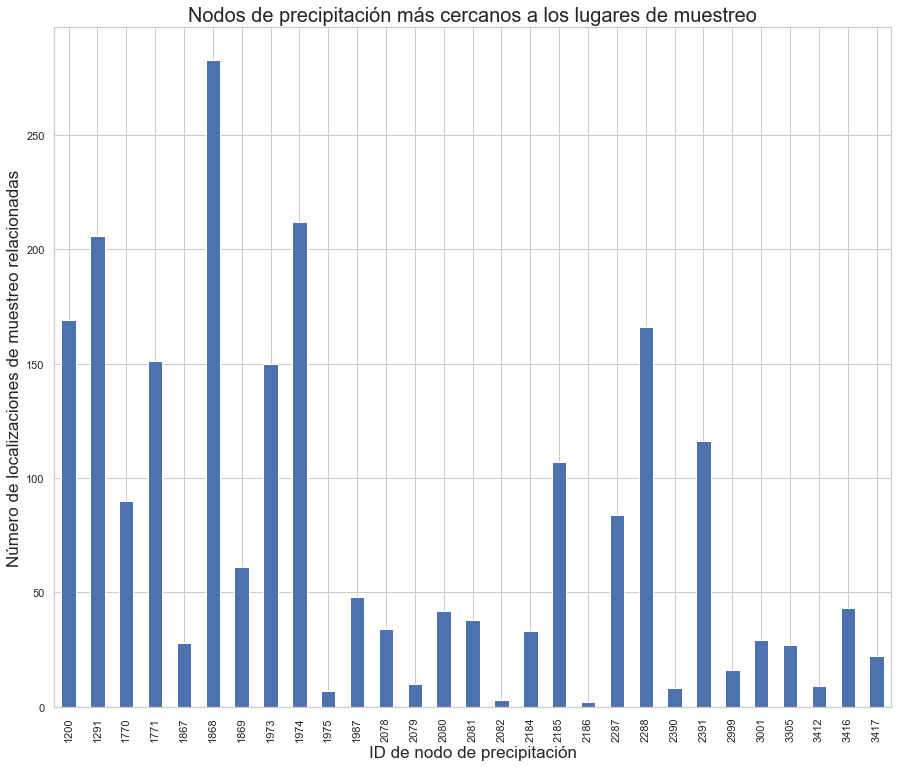

In [96]:
sorted_res_precip_closest.plot.bar()
#plt.hist(pairs['distance_m'], bins=15)
plt.title('Nodos de precipitación más cercanos a los lugares de muestreo', fontsize=20)
plt.xlabel('ID de nodo de precipitación', fontsize=17)
plt.ylabel('Número de localizaciones de muestreo relacionadas', fontsize=17)
plot_out = os.path.join(output_dir, 'localizaciones_asociadas_a_nodos_de_preciptacion_mas_cercanos.jpg')
plt.savefig(plot_out, dpi=300)

plt.show()

El nodo 1868 es el que más asociaciones tiene. Trabajamos sobre él para hacer el testeo de datos obtenidos.

In [98]:
df_1868 = df_related_precip_closest[df_related_precip_closest['index_grid'] == 1868]
print(f'Número de localizaciones asociadas al ID 1868 del nodo de precipitaciones = {len(df_1868.index)}')

Número de localizaciones asociadas al ID 1868 del nodo de precipitaciones = 283


In [99]:
print(df_1868)

     index_loc  index_grid     distance
118        118        1868  3477.704247
120        120        1868  3315.710046
121        121        1868  3524.534431
122        122        1868  3758.901045
123        123        1868  3820.490134
..         ...         ...          ...
657        657        1868  3287.910804
658        658        1868  2872.571307
659        659        1868  2829.944364
663        663        1868  2786.344854
666        666        1868  3504.108894

[283 rows x 3 columns]


**1. Verificación espacial**

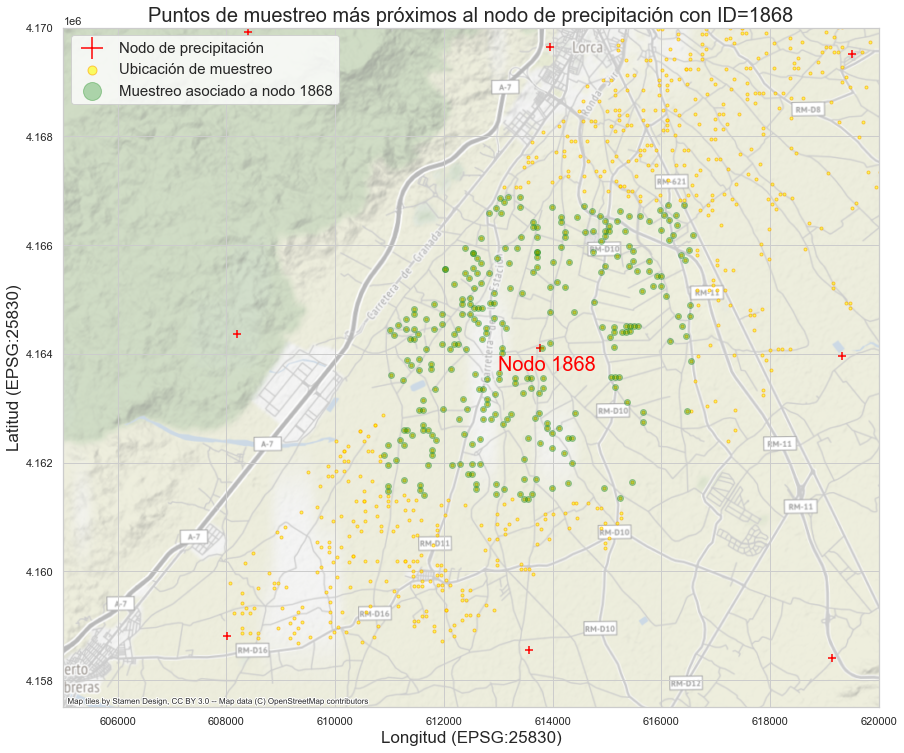

In [100]:
plt.rcParams["figure.figsize"] = (15,12.5)

ax = gdf_reduced_grid.plot(color='red', marker='+', markersize=50, label='Nodo de precipitación')

gdf_loc.plot(ax=ax, color='yellow', edgecolor='orange', marker='.', alpha=0.6, label='Ubicación de muestreo')

# En verde: ubicaciones de los puntos de muestreo más próximos a nodo de malla con ID=1868
gdf_loc.loc[df_1868.index].plot(ax=ax, color='green', marker='o', alpha=0.3, label='Muestreo asociado a nodo 1868')

plt.text(613000, 4163700, 'Nodo 1868', color='red', size=20)
# zoom a estas coordenadas proyectadas
ax.set_xlim(605000, 620000)
ax.set_ylim(4157500, 4170000)

cx.add_basemap(ax, crs=gdf_loc.crs.to_string(), alpha=0.5)
plt.legend(loc='upper left', prop={'size':15}, markerscale=3)
plt.xlabel(f'Longitud ({config.get("crs", "final_projected")})', fontsize=17)
plt.ylabel(f'Latitud ({config.get("crs", "final_projected")})', fontsize=17)
plt.title('Puntos de muestreo más próximos al nodo de precipitación con ID=1868', fontsize=20)
output_dir = os.path.abspath(config.get('directories', 'output_dir'))
plot_out = os.path.join(output_dir, 'localizaciones_mas_proximas_al_nodo_de_precipitacion_1868.jpg')
plt.savefig(plot_out, dpi=300)

plt.show()

**2. Verificación del valor de precipitaciones asociadas**

In [101]:
# Primer nodo de muestreo asociado a este subconjunto
id_grid = int(df_1868.iloc[0,:].loc[['index_grid']])
id_loc = int(df_1868.iloc[0,:].loc[['index_loc']])
print(id_grid)
print(id_loc)
print(df_1868.iloc[0,:])

1868
118
index_loc      118.000000
index_grid    1868.000000
distance      3477.704247
Name: 118, dtype: float64


In [102]:
# precipitacion asociada a este id_loc
print(df_muestreo_precipitacion_cercano.loc[:, id_loc].to_numpy())

# precipitaciones registradas en el fichero de precipitaciones
print(f'Precipitación registrada en el nodo identificado por: {id_grid}')
print(df_precip.loc[:, id_grid].to_numpy())

print('Medidas de precipitación para todos los lugares de muestreo asociados al nodo de precipitación 1868...')
for ind in df_1868.loc[:,'index_loc'].to_list():
    print(f'{ind} -> {df_muestreo_precipitacion_cercano.loc[:, ind].to_numpy()}')
    

[0.   0.41 0.   ... 0.   0.   0.  ]
Precipitación registrada en el nodo identificado por: 1868
[0.   0.41 0.   ... 0.   0.   0.  ]
Medidas de precipitación para todos los lugares de muestreo asociados al nodo de precipitación 1868...
118 -> [0.   0.41 0.   ... 0.   0.   0.  ]
120 -> [0.   0.41 0.   ... 0.   0.   0.  ]
121 -> [0.   0.41 0.   ... 0.   0.   0.  ]
122 -> [0.   0.41 0.   ... 0.   0.   0.  ]
123 -> [0.   0.41 0.   ... 0.   0.   0.  ]
127 -> [0.   0.41 0.   ... 0.   0.   0.  ]
128 -> [0.   0.41 0.   ... 0.   0.   0.  ]
131 -> [0.   0.41 0.   ... 0.   0.   0.  ]
132 -> [0.   0.41 0.   ... 0.   0.   0.  ]
138 -> [0.   0.41 0.   ... 0.   0.   0.  ]
139 -> [0.   0.41 0.   ... 0.   0.   0.  ]
140 -> [0.   0.41 0.   ... 0.   0.   0.  ]
141 -> [0.   0.41 0.   ... 0.   0.   0.  ]
142 -> [0.   0.41 0.   ... 0.   0.   0.  ]
143 -> [0.   0.41 0.   ... 0.   0.   0.  ]
148 -> [0.   0.41 0.   ... 0.   0.   0.  ]
149 -> [0.   0.41 0.   ... 0.   0.   0.  ]
150 -> [0.   0.41 0.   ... 0.   0. 

Mostramos los nodos de la malla de precipitaciones seleccionados

Número de nodos de malla cercanos = 29


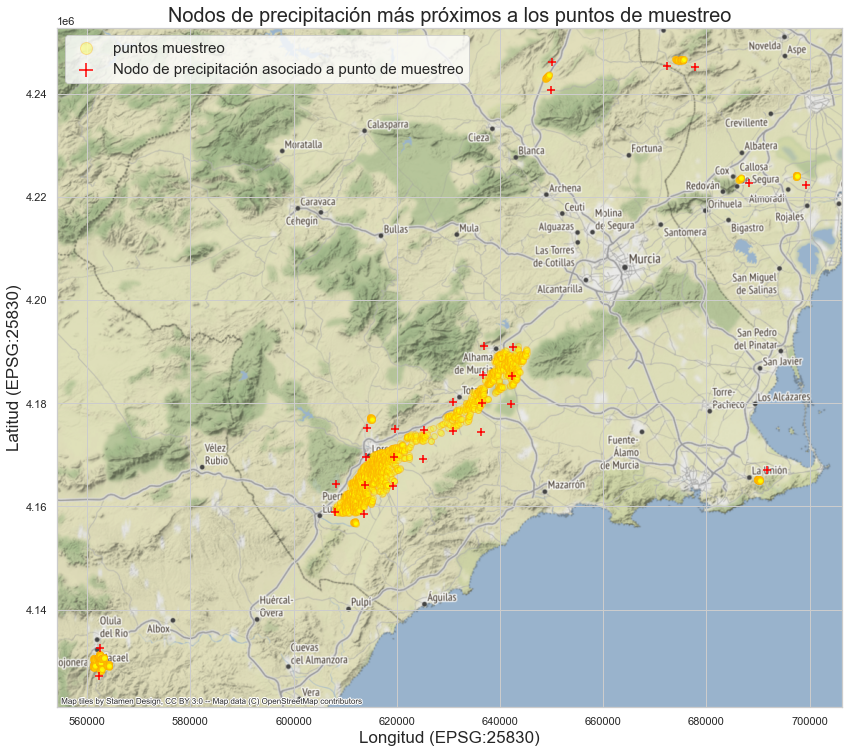

In [103]:
# Grid de nodos cercanos
plt.rcParams["figure.figsize"] = (15,12.5)

unique_grid_nodes = np.unique(df_related_precip_closest.index_grid)
print(f'Número de nodos de malla cercanos = {unique_grid_nodes.size}')

ax = gdf_loc.plot(color='yellow', edgecolor='orange', marker='o', alpha=0.3, label='puntos muestreo')
gdf_reduced_grid.loc[unique_grid_nodes].plot(ax=ax, color='red', marker='+', markersize=50, alpha=1, label='Nodo de precipitación asociado a punto de muestreo')
cx.add_basemap(ax, crs=gdf_loc.crs.to_string())
plt.legend(loc='upper left', prop={'size':15}, markerscale=2)
plt.title('Nodos de precipitación más próximos a los puntos de muestreo', fontsize=20)
plt.xlabel(f'Longitud ({config.get("crs", "final_projected")})', fontsize=17)
plt.ylabel(f'Latitud ({config.get("crs", "final_projected")})', fontsize=17)
output_dir = os.path.abspath(config.get('directories', 'output_dir'))
plot_out = os.path.join(output_dir, 'nodos_de_precipitacion_seleccionados.jpg')
plt.savefig(plot_out, dpi=300)

plt.show()

**Estadísticas sobre las distancias entre localizaciones de medida y nodos de la malla de precipitaciones**

In [104]:
dist = df_related_precip_closest['distance'].values
message = '(media, desviación estándar, mediana, máximo, mínimo) = ({:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}) m'
print(message.format(dist.mean(), dist.std(), np.median(dist), dist.max(), dist.min()))

(media, desviación estándar, mediana, máximo, mínimo) = (2206.17, 693.94, 2300.40, 3846.36, 51.96) m


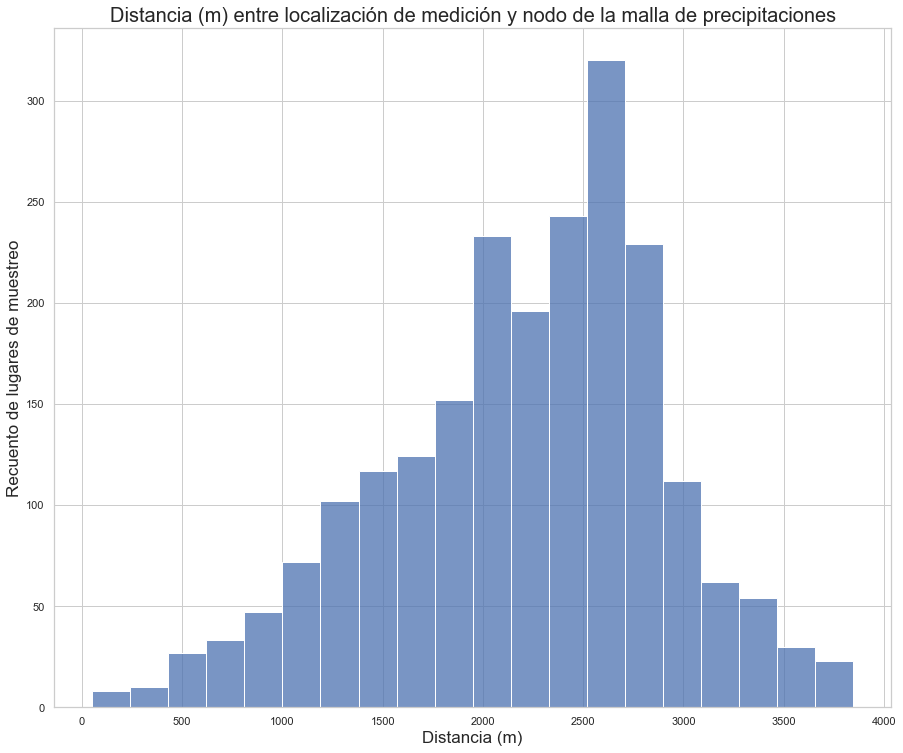

In [108]:
sns.set_theme(style="whitegrid")
sns.histplot(dist, bins=20)
plt.title('Distancia (m) entre localización de medición y nodo de la malla de precipitaciones', fontsize=20)
plt.xlabel("Distancia (m)", fontsize=17)
plt.ylabel("Recuento de lugares de muestreo", fontsize=17)
output_dir = os.path.abspath(config.get('directories', 'output_dir'))
plot_out = os.path.join(output_dir, 'histograma_distancias_nodos_precipitacion-puntos_muestreo.jpg')
plt.savefig(plot_out, dpi=300)

plt.show()

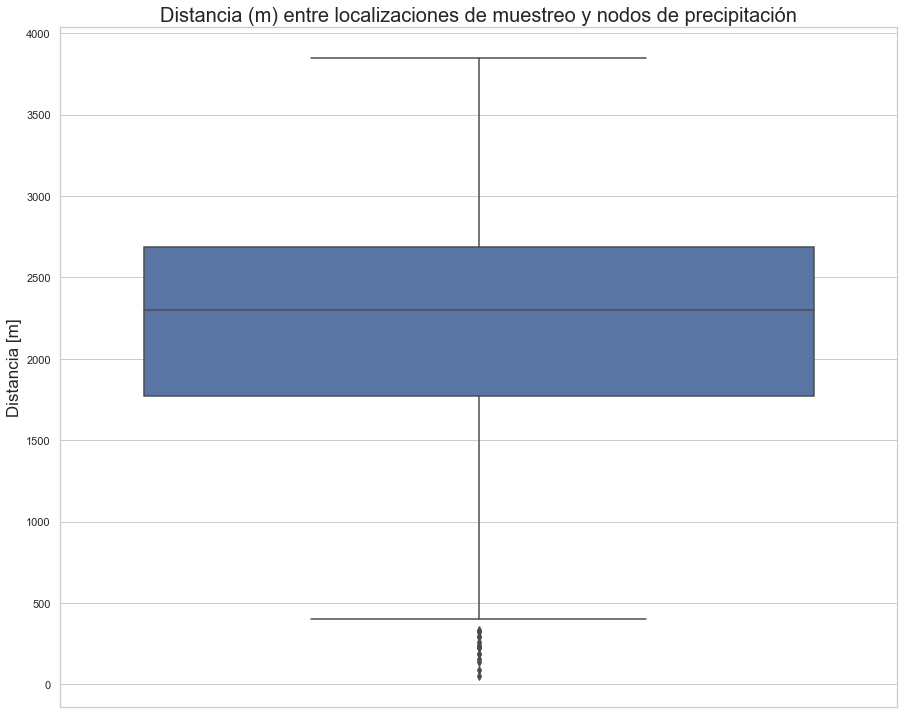

In [109]:
# gráfica de caja y bigotes

sns.boxplot(data=df_related_precip_closest, y='distance')
plt.title('Distancia (m) entre localizaciones de muestreo y nodos de precipitación', fontsize=20)
plt.ylabel('Distancia [m]', fontsize=17)
output_dir = os.path.abspath(config.get('directories', 'output_dir'))
plot_out = os.path.join(output_dir, 'boxplot_distancias_nodo_precipitacion-puntos_muestreo.jpg')
plt.savefig(plot_out, dpi=300)

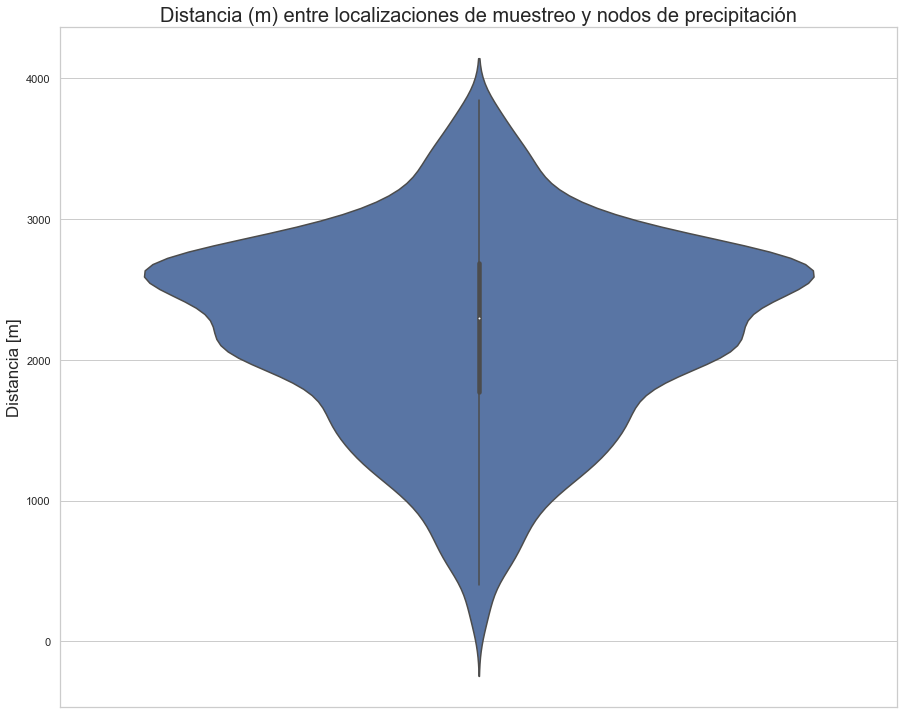

In [110]:
# gráfica de violín

sns.violinplot(data=df_related_precip_closest, y='distance')
plt.title('Distancia (m) entre localizaciones de muestreo y nodos de precipitación', fontsize=20)
plt.ylabel('Distancia [m]', fontsize=17)
output_dir = os.path.abspath(config.get('directories', 'output_dir'))
plot_out = os.path.join(output_dir, 'violinplot_distancias_nodo_precipitacion-puntos_muestreo.jpg')
plt.savefig(plot_out, dpi=300)

plt.show()

## 3. Piezometría

La piezometría es accesible a través de una URL que apunta a un fichero alojado en la web del **Ministerio de Transición Ecológica y Reto Demográfico** (parámetro *piezometry_url* del fichero *config.ini*). Está comprimido en formato ZIP. Contiene una base de datos *MS Access* con dos pestañas:

- La primera contiene, entre otras, la ubicación de los puntos en los que se toman las medida. 
- La segunda contiene la estación piezométrica, la medida registrada y fecha.

Vamos a homogeneizar los formatos de los ficheros de entrada. Para ello, generaremos un fichero CSV por cada una de las tablas contenidas en la base de datos MS Access de la piezometría.

In [113]:
data_dir = os.path.abspath(config.get('directories', 'data_dir'))
piezometers_path = os.path.join(data_dir, 'piezometers.csv') # CSV con información sobre los puntos de medida de piezometría
levels_path = os.path.join(data_dir, 'levels_piezometry.csv') # CSV con el resultado de las mediciones miezométricas

In [115]:
# Descarga del fichero de datos piezométricos
piezometry_url = config.get('urls', 'piezometry_url')
prefix, name = os.path.split(piezometry_url)
piezo_path = os.path.join(data_dir, name)

piezo_res = 1
if not os.path.exists(piezo_path):
    print(f"Descargando '{piezometry_url}'. Por favor, espere unos segundos...")
    piezo_res = get_url(piezometry_url, data_dir)
    print("Descarga terminada!")
else:
    print(f'"{piezo_path}" ya descargado.')

"C:\Users\Cesar\desarrollos\GITLAB\sarai_piezo_precip\data\basedatospiezometria_tcm30-533415.zip" ya descargado.


In [122]:
print(pyodbc.drivers())

['SQL Server', 'ODBC Driver 17 for SQL Server']


In [123]:
df_piezometers = None
df_levels = None

# Si existen los CSV de piezometros y niveles piezometricos, los cargamos en memoria
if os.path.exists(piezometers_path):
    df_piezometers = pd.read_csv(piezometers_path)
if os.path.exists(levels_path):
    df_levels = pd.read_csv(levels_path)
    
# Si no existe uno de los dos ficheros y la descarga del ZIP de piezometría se ha 
# llevado a cabo sin problemas, descomprimimos, leemos la base de datos y 
# almacenamos cada tabla en sendos dataframes.
if (df_levels is None or df_piezometers is None) and piezo_res > 0:
    # Descompresión del fichero
    root, name = os.path.split(piezometry_url)
    piezo_path = os.path.join(data_dir, name)

    if unzip(piezo_path, data_dir) == 0:
        # Lectura del fichero de base de datos
        piezo_db_path = glob.glob(os.path.join(data_dir, '*.mdb'))
        df_piezometers, df_levels = read_db_piezometry(piezo_db_path[0])

"C:\Users\Cesar\desarrollos\GITLAB\sarai_piezo_precip\data\basedatospiezometria_tcm30-533415.zip" content:
['06_Piezo_webMinisterio_tablas_GEOportal_2020_09062022.mdb']
path=C:\Users\Cesar\desarrollos\GITLAB\sarai_piezo_precip\data\06_Piezo_webMinisterio_tablas_GEOportal_2020_09062022.mdb


InterfaceError: ('IM002', '[IM002] [Microsoft][Administrador de controladores ODBC] No se encuentra el nombre del origen de datos y no se especificó ningún controlador predeterminado (0) (SQLDriverConnect)')

In [116]:
ind_piezometer = config.get('fields', 'piezo_id')
print(f'Piezometer index field = "{ind_piezometer}"')
df_piezometers = df_piezometers.set_index(ind_piezometer, drop=False)
df_levels = df_levels.set_index(ind_piezometer, drop=False)
piezo_date = config.get('fields', 'piezo_date')
print(f'Campo de fecha para las medidas piezométricas = "{piezo_date}"')
if piezo_date in df_levels.columns:
    print(f'Renombrando el campo fecha de piezometría de "{piezo_date}" a "fecha" en el DataFrame de medidas.')
    df_levels.rename(columns={'FechaP':'fecha'}, inplace=True)

Piezometer index field = "IDPIEZ"


NameError: name 'df_piezometers' is not defined

In [ ]:
print(df_piezometers.info())

In [ ]:
df_piezometers.head()

In [ ]:
df_levels.info()

In [ ]:
df_levels.head()

**Guardo los datos de piezometría en fichero CSV**

In [ ]:
df_piezometers.to_csv(piezometers_path, index=False)
df_levels.to_csv(levels_path, index=False)

#### Asociación entre punto de muestreo y piezómetro más próximo

Se tomará como distancia límite el campo *radius* (en metros) de la seccion *buffer* del fichero *config.ini* para que se considere esa asociación como válida.

In [ ]:
# Creo el campo de geometría para los datos de los piezómetros

# Presupongo sistema de referencia geográfico
piezo_lon = config.get('fields', 'piezo_lon_geo')
piezo_lat = config.get('fields', 'piezo_lat_geo')
piezo_crs = crs=config.get('crs', 'piezo_geographic')

if len(config.get('fields', 'piezo_lon_proj')) > 0:  
    # Si hay coordenadas proyectadas, cambio la informacion anterior
    print('Usando coordenadas proyectadas en piezometría.')
    piezo_lon = config.get('fields', 'piezo_lon_proj')
    piezo_lat = config.get('fields', 'piezo_lat_proj')
    piezo_crs = config.get('crs', 'piezo_projected')

print(f'Cooordinates fields for piezometer locations = ({piezo_lon}, {piezo_lat})')
geom = gpd.points_from_xy(df_piezometers[piezo_lon], df_piezometers[piezo_lat], crs=piezo_crs)

In [ ]:
# Genero el objeto GeoDataFrame
gdf_piezometers = gpd.GeoDataFrame(df_piezometers, geometry=geom)
ind_piezometer = config.get('fields', 'piezo_id')
print(f'Piezometers GeoDataframe index field = "{ind_piezometer}"')
gdf_piezometers = gdf_piezometers.set_index(ind_piezometer, drop=False)

Proyecto al sistema de referencia proyectado común a todas las entradas de datos.

In [ ]:
gdf_piezometers.to_crs(config.get('crs', 'final_projected'), inplace=True)

In [ ]:
print(gdf_piezometers.info())

In [ ]:
gdf_piezometers.head()

Comprobación de la unicidad del campo *piezo_label*.

In [ ]:
# Comprobación de sistema de referencia de los puntos de muestreo
print(f'SR de los puntos de muestreo = {gdf_loc.crs}')

# Y de la ubicación de los piezómetros
print(f'SR de los puntos de muestreo = {gdf_piezometers.crs}')

**Muestro ubicaciones**

In [ ]:
plt.rcParams["figure.figsize"] = (15,12.5)

ax = gdf_piezometers.plot(color='red', marker='.', markersize=10, label="Piezómetros")

gdf_loc.plot(ax=ax, color='blue', alpha=0.3, marker='.', markersize=10, label="Muestreos")
cx.add_basemap(ax, crs=gdf_loc.crs.to_string())
plt.legend(loc='lower right', prop={'size':20}, markerscale=3)
plt.title('Piezómetros registrados y puntos de muestreo', fontsize=20)
plt.xlabel(f'Longitud ({config.get("crs", "final_projected")})', fontsize=17)
plt.ylabel(f'Latitud ({config.get("crs", "final_projected")})', fontsize=17)
output_dir = os.path.abspath(config.get('directories', 'output_dir'))
plot_out = os.path.join(output_dir, 'piezometros_registrados_y_puntos_de_muestreo.jpg')
plt.savefig(plot_out, dpi=300)

plt.show()

Limito la malla al cuadrado determinado por las coordenadas extremas de las localizaciones de muestreo.

In [ ]:
big_radius = float(config.get('buffer', 'radius')) + 1000 # amplío el tamaño de buffer propuesto en 1000 m alrededor de cada punto
gdf_loc["buffered"] = gdf_loc.buffer(big_radius) 

# cambio la geometría por defecto de puntos a buffers
gdf_loc = gdf_loc.set_geometry("buffered")

# coordenadas extremas de los buffers
minx, miny, maxx, maxy = gdf_loc.total_bounds

print('Área de interés:')
print(f'\t(minx, miny, maxx, maxy) = ({minx}, {miny}, {maxx}, {maxy})')

# establezco de nuevo la geometría por defecto a la columna de puntos
gdf_loc = gdf_loc.set_geometry("geometry")


Genero un polígono a partir de los límites obtenidos en el punto anterior

In [ ]:
pol_geom = Polygon([(minx, miny), (minx, maxy), (maxx, maxy), (maxx, miny), (minx, miny)])
polygon = gpd.GeoDataFrame(index=[0], crs= config.get('crs', 'final_projected'), geometry=[pol_geom])

In [ ]:
inside = gdf_piezometers.within(polygon.geometry[0])
print(f'Número de piezómetros en los límites de las localizaciones de muestreo = {inside.sum()}')

In [ ]:
# Zoom a la zona de muestreo
gdf_reduced_piezometers = gdf_piezometers[inside]
gdf_reduced_piezometers = gdf_reduced_piezometers.to_crs(config.get('crs', 'final_projected'))

In [ ]:
plt.rcParams["figure.figsize"] = (15,12.5)

ax = gdf_reduced_piezometers.plot(color='red', marker='+', label='Ubicaciones de piezómetros')

gdf_loc.plot(ax=ax, color='yellow', edgecolor='orange', alpha=0.3, marker='.', label='Estaciones de muestreo')
cx.add_basemap(ax, crs=gdf_loc.crs.to_string())
plt.legend(loc='upper left', prop={'size':15}, markerscale=3)
plt.title('Piezómetros localizados en la zona de muestreo', fontsize=20)
plt.xlabel(f'Longitud ({config.get("crs", "final_projected")})', fontsize=17)
plt.ylabel(f'Latitud ({config.get("crs", "final_projected")})', fontsize=17)
output_dir = os.path.abspath(config.get('directories', 'output_dir'))
plot_out = os.path.join(output_dir, 'piezometros_en_zona_de_muestreo.jpg')
plt.savefig(plot_out, dpi=300)

plt.show()

In [ ]:
df_levels.head()

In [ ]:
rad_buffer_m = float(config.get('buffer', 'radius'))
measures_piezo, related_piezo = get_piezometry(gdf_loc, gdf_reduced_piezometers, df_levels, radius_m=rad_buffer_m)

In [ ]:
df_related_piezo = pd.DataFrame.from_dict(related_piezo)

In [ ]:
print(f'Número de medidas de piezometría obtenidas = {len(measures_piezo.keys())}\n')

for i in range(len(related_piezo['index_grid'])):
    print(f"(i_loc, i_grid, distance, num_datos_piezo)-> ({related_piezo['index_loc'][i]}, {related_piezo['index_grid'][i]}, {related_piezo['distance'][i]}, {len(measures_piezo[related_piezo['index_loc'][i]])})")


Estadísticas de las distancias entre localizaciones de muestreo y piezómetros cercanos

In [ ]:
dist = df_related_piezo['distance'].values
message = '(num_datos, media, desviación estándar, mediana, máximo, mínimo) = ({}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}) m'
print(message.format(dist.size, dist.mean(), dist.std(), np.median(dist), dist.max(), dist.min()))

In [ ]:
index_closest_piezometers = np.unique(df_related_piezo.index_grid.values)
print(f'Número de piezómetros seleccionados = {len(index_closest_piezometers)}')

Imprimo las ubicaciones de esos piezometros

In [ ]:
plt.rcParams["figure.figsize"] = (15,12.5)

ax = gdf_loc.plot(color='yellow', edgecolor='orange', alpha=0.1, marker='o', label='Estaciones de muestreo')
gdf_reduced_piezometers.plot(ax=ax, color='gray', marker='+', markersize=30, label='Ubicaciones de piezómetros')

gdf_reduced_piezometers.loc[index_closest_piezometers,:].plot(ax=ax, color='red', marker='+', markersize=70, label='Piezómetros seleccionados')
cx.add_basemap(ax, crs=gdf_loc.crs.to_string())
plt.legend(loc='upper left', prop={'size':15}, markerscale=2)
plt.title('Piezómetros asociados a los puntos de muestreo', fontsize=20)
plt.xlabel(f'Longitud ({config.get("crs", "final_projected")})', fontsize=17)
plt.ylabel(f'Latitud ({config.get("crs", "final_projected")})', fontsize=17)
output_dir = os.path.abspath(config.get('directories', 'output_dir'))
plot_out = os.path.join(output_dir, 'piezometros_seleccionados.jpg')
plt.savefig(plot_out, dpi=300)

plt.show()



Veamos qué puntos con datos de piezometría son las que más frecuentemente se relacionan con los puntos de muestreo.

In [ ]:
res = df_related_piezo['index_grid'].value_counts()
sorted_res = res.sort_index()
#res.columns=['id','count']
print(sorted_res)

In [ ]:
sorted_res.plot.bar()
#plt.hist(pairs['distance_m'], bins=15)
plt.title('Estaciones piezométricas más usadas', fontsize=20)
plt.xlabel('IDPIEZ', fontsize=17)
plt.ylabel('Localizaciones de muestreo', fontsize=17)
plot_out = os.path.join(output_dir, 'localizaciones_asociadas_a_piezometros.jpg')
plt.savefig(plot_out, dpi=300)
plt.show()

In [ ]:
gdf_reduced_piezometers.loc[[2015]]

Muestro las localizaciones de muestreo asociadas a la estación peizométrica más relacionada (index_grid = 2015)

In [ ]:
plt.rcParams["figure.figsize"] = (15,12.5)

ax = gdf_loc.plot(color='gray', edgecolor='gray', alpha=0.1, marker='o', label='Otras estaciones de muestreo')

selected_muestreo = df_related_piezo['index_grid'] == 2015
indexes = np.unique(df_related_piezo[selected_muestreo]['index_loc'].values)

gdf_loc.loc[indexes,:].plot(ax=ax, color='magenta', alpha=0.1, marker='o', label='Estaciones de muestreo 2015')
cx.add_basemap(ax, crs=gdf_loc.crs.to_string(), alpha=0.5)
gdf_reduced_piezometers[gdf_reduced_piezometers.index != 2015].plot(ax=ax, color='orange', marker='+', markersize=70, label='Otros piezómetros seleccionados')
gdf_reduced_piezometers.loc[[2015]].plot(ax=ax, color='blue', marker='+', markersize=50, label='Piezómetro con ID = 2015')

plt.legend(loc='upper left', prop={'size':15}, markerscale=2)
plt.title('Localizaciones asociadas al piezómetro con ID=2015', fontsize=20)
plt.xlabel(f'Longitud ({config.get("crs", "final_projected")})', fontsize=17)
plt.ylabel(f'Latitud ({config.get("crs", "final_projected")})', fontsize=17)
output_dir = os.path.abspath(config.get('directories', 'output_dir'))
plot_out = os.path.join(output_dir, 'localizaciones_asociadas_piezometro_2015.jpg')
plt.savefig(plot_out, dpi=300)
plt.show()

Hago algo de estadística con las distancias: histograma, diagrama de caja y bigotes y diagrama de violín. Se trata de visualizar la distribución de distancias entre los puntos de muestro y las ubicaciones de las estaciones piezométricas.


In [ ]:
sns.set_theme(style="whitegrid")
sns.histplot(df_related_piezo['distance'].values, bins=20)
plt.title('Distancia (m) entre localización de los puntos de muestreo y los piezómetros', fontsize=20)
plt.xlabel("Distancia (m)", fontsize=17)
output_dir = os.path.abspath(config.get('directories', 'output_dir'))
plot_out = os.path.join(output_dir, 'histograma_distancias_a_piezometros.jpg')
plt.savefig(plot_out, dpi=300)
plt.show()

In [ ]:
# gráfica de caja y bigote
sns.set_theme(style="whitegrid")
sns.boxplot(data=df_related_piezo, y='distance')
plt.title('Distancia entre puntos de muestreo y ubicaciones de piezómetros', fontsize=20)
plt.ylabel('Distancia [m]', fontsize=17)
output_dir = os.path.abspath(config.get('directories', 'output_dir'))
plot_out = os.path.join(output_dir, 'boxplot_distancias_a_piezometros.jpg')

plt.savefig(plot_out, dpi=300)

plt.show()

In [ ]:
# gráfica de violín

sns.set_theme(style="whitegrid")

sns.violinplot(data=df_related_piezo, y='distance')
plt.title('Distancia entre puntos de muestreo y ubicaciones de piezómetros', fontsize=20)
plt.ylabel('Distancia [m]', fontsize=17)
output_dir = os.path.abspath(config.get('directories', 'output_dir'))
plot_out = os.path.join(output_dir, 'violinplot_distancias_a_piezometros.jpg')
plt.savefig(plot_out, dpi=300)

plt.show()

In [ ]:
# Vuelco el contenido del dataframe de correspondencias entre localizaciones de muestreo y piezómetros a un fichero
output_dir = os.path.abspath(config.get('directories', 'output_dir'))
related_piezo_path = os.path.join(output_dir, 'correspondencias_piezometros.csv')
df_related_piezo.to_csv(related_piezo_path, index=False)

**Fichero de salida para las medidas piezométricas**

In [ ]:
print(measures_piezo.keys())

In [ ]:
measures_piezo[0]

In [ ]:

for k, v in measures_piezo.items():
    print(f'{k} -> {v}')
    break

In [ ]:
for k, v in measures_piezo.items():
    print(f"{k}:{gdf_loc.loc[k, config.get('fields', 'location_label')]}")
    break

In [ ]:
piezo_field = config.get('fields', 'piezo_measure')
for k, v in measures_piezo.items():
    # v es un dataframe con columnas 'fecha' y 'Cota_NP_msnm'. Cambio el nombre de la columna 'Cota_NP_msnm' al ID del punto de muestreo
    # temp = v.rename(columns={piezo_field:int(k)})
    temp = v.rename(columns={piezo_field:gdf_loc.loc[k, config.get('fields', 'location_label')]})
    
print(temp)

In [ ]:
# Fichero de salida para las medidas piezométricas

df_data_piezo = None
piezo_field = config.get('fields', 'piezo_measure')
print(f'Piezometry measure field = "{piezo_field}"')
for k, v in measures_piezo.items():
    # v es un dataframe con columnas 'fecha' y 'Cota_NP_msnm'. Cambio el nombre de la columna 'Cota_NP_msnm' al ID del punto de muestreo
    # temp = v.rename(columns={piezo_field:int(k)})
    temp = v.rename(columns={piezo_field:gdf_loc.loc[k, config.get('fields', 'location_label')]})

    if df_data_piezo is None:
        df_data_piezo = temp
    else:
        df_data_piezo = df_data_piezo.merge(temp, left_on='fecha', right_on='fecha', how='outer')

print(df_data_piezo.info())

In [ ]:
df_data_piezo.head()

In [ ]:
output_dir = os.path.abspath(config.get('directories', 'output_dir'))
piezometrias_out = os.path.join(output_dir, config.get('paths', 'out_longer_piezo'))
# tiempo de escritura de fichero
ini_time = int(time.time())
df_data_piezo.to_csv(piezometrias_out, index=False, header=True)
final_time = int(time.time())
print(f'Tiempo de escritura del fichero "{piezometrias_out}" = {final_time - ini_time} s')

In [ ]:
# Primeros 50 resultados.
print(df_data_piezo.head(50))

In [ ]:
# Últimos 50 resultados
print(df_data_piezo.tail(50))